In [1]:
import os
import pandas as pd
import numpy as np
import sklearn
import scanpy as sc
import anndata
import shap
import subprocess
import umap
import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt

# import tensorflow as tf

import mgitools.os_helpers as os_helpers

In [2]:
%load_ext autoreload 

In [3]:
%autoreload 2

In [4]:
from pollock.models.model import (embed_from_anndata, predict_from_anndata,
                                  load_from_directory, balancedish_training_generator,
                                 PollockDataset, PollockModel)
from pollock.models.explain import explain_predictions

## unannotated ADM

In [ ]:
adata = sc.read_h5ad('../benchmarking/data/10232020_harmonized/teir_1/scRNAseq/pdac.h5ad')
module_fp = '../benchmarking/results/10272020_teir1/scRNAseq/pdac/pollock_module/'

In [ ]:
adata

In [ ]:
sc.pl.umap(adata, color='cell_type')

In [ ]:
predictions = predict_from_anndata(adata.copy(), module_fp)
predictions

In [ ]:
adata.obs = pd.merge(adata.obs, predictions, right_index=True, left_index=True)
adata.obs

In [ ]:
embeddings = embed_from_anndata(adata.copy(), module_fp)
embeddings

In [ ]:
adata.obsm['X_embedding'] = embeddings.values

In [ ]:
from sklearn.preprocessing import StandardScaler
adata.obsm['X_umap_embedding'] = umap.UMAP().fit_transform(StandardScaler().fit_transform(embeddings.values))

In [ ]:
sc.pl.embedding(adata, basis='X_umap_embedding', color='cell_type', )

In [ ]:
filtered = adata[[True if c in ['Acinar', 'Malignant'] else False for c in adata.obs['cell_type']]].copy()
filtered = filtered[[True if x in ['Malignant', 'Acinar', 'Epithelial'] else False
                     for x in filtered.obs['predicted_cell_type']]]
filtered

In [ ]:
sc.pl.umap(filtered, color=['cell_type', 'predicted_cell_type', 'cell_type_probability'])

In [ ]:
sc.pl.umap(filtered, color=['cell_type', 'predicted_cell_type', 'cell_type_probability'])

In [ ]:
sc.pl.embedding(filtered, basis='X_umap_embedding',
                color=['cell_type', 'predicted_cell_type', 'cell_type_probability'])

In [ ]:
sc.pl.embedding(filtered, basis='X_umap_embedding',
                color=['probability_Acinar', 'probability_Malignant', 'probability_Epithelial'])

In [ ]:
explain, rest = balancedish_training_generator(filtered, cell_type_key='cell_type', n_per_cell_type=500, oversample=False,
                                        split=1.)
background, _ = balancedish_training_generator(rest, cell_type_key='cell_type', n_per_cell_type=50, oversample=False,
                                           split=1.)
explain

In [ ]:
background

In [ ]:
sc.pl.umap(explain, color='cell_type')

In [ ]:
df = explain_predictions(explain.copy(), background.copy(), module_filepath=module_fp,
                    prediction_key='cell_type', )
df

In [ ]:
m1 = explain.copy()
# sc.pp.highly_variable_genes(adata, n_top_genes=3000)
sc.pp.log1p(m1)
sc.pp.scale(m1)
sc.pp.neighbors(m1)
sc.pp.pca(m1)

sc.tl.umap(m1)
sc.tl.leiden(m1, resolution=.05)
m1

In [ ]:
sc.pl.umap(m1, color=['leiden', 'cell_type', 'probability_Acinar', 'probability_Malignant',
                                'sample'],
          ncols=2)

In [ ]:
# grab the ductal
malignant = anndata.AnnData(X=df.values)
malignant.var.index = list(df.columns)
malignant.obs.index = df.index.to_list()
malignant.obs = pd.merge(malignant.obs, explain.obs, right_index=True, left_index=True)
malignant

In [ ]:
feature_adata = malignant.copy()
sc.pp.highly_variable_genes(feature_adata, n_top_genes=3000)
highly_variable = feature_adata.var['highly_variable'].to_list()
feature_adata = malignant.copy()
feature_adata.X = np.log1p(feature_adata.X * 100)
sc.pp.scale(feature_adata)
sc.pp.neighbors(feature_adata)
sc.pp.pca(feature_adata)

sc.tl.umap(feature_adata)
sc.tl.leiden(feature_adata, resolution=.2)
feature_adata

In [ ]:
sc.pl.umap(feature_adata, color=['leiden', 'cell_type', 'probability_Acinar', 'probability_Malignant',
                                'sample'],
          ncols=2)

In [ ]:
# read in m1 clusters
id2c = dict(zip(m1.obs.index, m1.obs['leiden']))
feature_adata.obs['expression_based'] = [id2c[i] for i in feature_adata.obs.index]
sc.pl.umap(feature_adata, color=['expression_based'],
          ncols=2)

In [ ]:
# read in feature_adata clusters
id2c = dict(zip(feature_adata.obs.index, feature_adata.obs['leiden']))
m1.obs['feature_based'] = [id2c[i] for i in m1.obs.index]
sc.pl.umap(m1, color=['feature_based'],
          ncols=2)

In [ ]:
markers = {
    'malignant': ['EPCAM', 'KRT18', 'CDH1', 'MUC5AC'],
    'acinar': ['CELA3A', 'CTRB1', 'CTRB2', 'PRSS2']
}
sc.pl.heatmap(feature_adata, var_names=markers, groupby='leiden')

In [ ]:
rank = feature_adata[:, highly_variable].copy()
sc.tl.rank_genes_groups(rank, 'leiden', method='wilcoxon', groups=['0', '1'])

In [ ]:
sc.pl.rank_genes_groups_heatmap(rank, groups=['0', '1'])

In [ ]:
rank = feature_adata[:, highly_variable].copy()
sc.tl.rank_genes_groups(rank, 'leiden', method='wilcoxon', groups=['2'])

In [ ]:
sc.pl.rank_genes_groups_heatmap(rank, groups=['2'])

In [ ]:
rank = m1[:, highly_variable].copy()
sc.tl.rank_genes_groups(rank, 'feature_based', method='wilcoxon')

In [ ]:
sc.pl.rank_genes_groups_heatmap(rank)

In [ ]:
# integrate the embedddings into m1
m1.obsm['X_umap_explain'] = feature_adata.obsm['X_umap'].copy()
m1

In [ ]:
color = ['EPCAM', 'CDH1', 'MUC5AC']
sc.pl.embedding(m1, basis='X_umap_explain', color=color)

In [ ]:
sc.pl.umap(feature_adata, color=color, vmax=5.,)

In [ ]:
## try training just on acinar/ductal
train = adata[[True if x in ['Acinar', 'Malignant'] else False for x in adata.obs['cell_type']]]
train

In [ ]:
from collections import Counter
from pollock.models.model import PollockDataset, PollockModel
Counter(train.obs['cell_type'])

In [ ]:
pds = PollockDataset(train.copy(), cell_type_key='cell_type', n_per_cell_type=1000,
                    oversample=True, dataset_type='training', )

In [ ]:
pm = PollockModel(pds.cell_types, pds.train_adata.shape[1], alpha=.0001, latent_dim=25, )

In [ ]:
pm.fit(pds, epochs=10)

In [ ]:
module_save_filepath = '../benchmarking/sandbox/acinar_malignant_model'
pm.save(pds, module_save_filepath)

In [ ]:
two_class_embeddings = embed_from_anndata(train.copy(), module_save_filepath)
two_class_embeddings

In [ ]:
m2 = train.copy()
sc.pp.log1p(m2)
sc.pp.highly_variable_genes(m2, n_top_genes=3000)
sc.pp.scale(m2)
sc.pp.neighbors(m2)
sc.pp.pca(m2)

sc.tl.umap(m2)
sc.tl.leiden(m2, resolution=.05)
m2

In [ ]:
m2.obsm['X_embedding'] = two_class_embeddings.values
m2.obsm['X_umap_embedding'] = umap.UMAP().fit_transform(StandardScaler().fit_transform(two_class_embeddings.values))

In [ ]:
preds = predict_from_anndata(train.copy(), module_save_filepath)
preds

In [ ]:
m2.obs = pd.merge(m2.obs, preds, left_index=True, right_index=True)

In [ ]:
sc.pl.umap(m2, color=['cell_type', 'probability_Acinar', 'probability_Malignant'])

In [ ]:
sc.pl.embedding(m2, basis='X_umap_embedding', color=['cell_type', 'probability_Acinar', 'probability_Malignant'])

In [ ]:
explained = feature_adata.obs.index.to_list()
reduced = m2[explained].copy()
reduced

In [ ]:
sc.pl.umap(reduced, color=['cell_type', 'probability_Acinar', 'probability_Malignant'])

In [ ]:
sc.pl.embedding(reduced, basis='X_umap_embedding', color=['cell_type', 'probability_Acinar', 'probability_Malignant'])

In [ ]:
reduced.obsm['X_umap_explain'] = m1.obsm['X_umap_explain'].copy()
reduced

In [ ]:
sc.pl.embedding(reduced, basis='X_umap_explain', color=['cell_type', 'probability_Acinar', 'probability_Malignant'])

In [ ]:
acinar_explain = explain.copy()
acinar_explain.obs['cell_type'] = 'Acinar'
malignant_explain = explain.copy()
malignant_explain.obs['cell_type'] = 'Malignant'

In [ ]:
df = explain_predictions(acinar_explain.copy(), background.copy(), module_filepath=module_fp,
                    prediction_key='cell_type', )
df

In [ ]:
# grab the ductal
mixed = anndata.AnnData(X=df.values)
mixed.var.index = list(df.columns)
mixed.obs.index = df.index.to_list()
mixed.obs = pd.merge(mixed.obs, acinar_explain.obs, right_index=True, left_index=True)
mixed

In [ ]:
acinar_feature_adata = mixed.copy()
sc.pp.highly_variable_genes(acinar_feature_adata, n_top_genes=3000)
highly_variable = acinar_feature_adata.var['highly_variable'].to_list()
acinar_feature_adata = mixed.copy()
acinar_feature_adata.X = np.log1p(acinar_feature_adata.X * 100)
sc.pp.scale(acinar_feature_adata)
sc.pp.neighbors(acinar_feature_adata)
sc.pp.pca(acinar_feature_adata)

sc.tl.umap(acinar_feature_adata)
sc.tl.leiden(acinar_feature_adata, resolution=.2)
acinar_feature_adata

In [ ]:
sc.pl.umap(acinar_feature_adata, color=['leiden', 'cell_type', 'probability_Acinar', 'probability_Malignant',
                , 'sample'],
          ncols=2)

In [ ]:
genes = ['CELA3A', 'CTRB1', 'CTRB2', 'PRSS2']
sc.pl.umap(acinar_feature_adata, color=genes,
          ncols=3)

In [ ]:
mdf = explain_predictions(malignant_explain.copy(), background.copy(), module_filepath=module_fp,
                    prediction_key='cell_type', )
mdf

In [ ]:
# grab the ductal
mixed = anndata.AnnData(X=mdf.values)
mixed.var.index = list(mdf.columns)
mixed.obs.index = mdf.index.to_list()
mixed.obs = pd.merge(mixed.obs, malignant_explain.obs, right_index=True, left_index=True)
mixed

In [ ]:
mal_feature_adata = mixed.copy()
sc.pp.highly_variable_genes(mal_feature_adata, n_top_genes=3000)
highly_variable = mal_feature_adata.var['highly_variable'].to_list()
mal_feature_adata = mixed.copy()
mal_feature_adata.X = np.log1p(mal_feature_adata.X * 100)
sc.pp.scale(mal_feature_adata)
sc.pp.neighbors(mal_feature_adata)
sc.pp.pca(mal_feature_adata)

sc.tl.umap(mal_feature_adata)
sc.tl.leiden(mal_feature_adata, resolution=.2)
mal_feature_adata

In [ ]:
sc.pl.umap(mal_feature_adata, color=['leiden', 'cell_type', 'probability_Acinar', 'probability_Malignant',
                'probability_Epithelial', 'sample'],
          ncols=2)

In [ ]:
genes = ['EPCAM', 'MUC5AC']
sc.pl.umap(mal_feature_adata, color=genes,
          ncols=3)

In [ ]:
np.count_nonzero(m1.obs.index==mal_feature_adata.obs.index)

In [ ]:
m1.obs['malignant_feature_clusters'] = mal_feature_adata.obs['leiden'].to_list()
m1.obs

In [ ]:
m1.obsm['X_umap_explain_malignant'] = mal_feature_adata.obsm['X_umap'].copy()

In [ ]:
sc.pl.embedding(m1, basis='X_umap_explain_malignant', color=['leiden', 'cell_type', 'probability_Acinar',
            'probability_Malignant', 'probability_Epithelial', 'sample', 'malignant_feature_clusters'], ncols=2)

In [ ]:
sc.pl.umap(m1, color=['leiden', 'cell_type', 'probability_Acinar',
            'probability_Malignant', 'probability_Epithelial', 'sample', 'malignant_feature_clusters'], ncols=2)

In [ ]:
sc.pl.embedding(m1, basis='X_umap_explain_malignant', color=['EPCAM', 'CEACAM6', 'KRT6A', 'KRT5'], ncols=2)

In [ ]:
sc.tl.rank_genes_groups(m1, groupby='malignant_feature_clusters')
sc.pl.rank_genes_groups_heatmap(m1)

In [ ]:
sc.pl.rank_genes_groups_heatmap(m1, groups=['2'], n_genes=30)

In [ ]:
sc.pl.embedding(m1, basis='X_umap_explain_malignant', color=['SOX9', 'RALA'], ncols=2)

## nadja snATACseq

In [ ]:
from importlib import reload

In [ ]:
import pollock
reload(pollock)

In [47]:
peaks = sc.read_h5ad('/home/estorrs/rds_conversion/data/snATACseq/brca/brca_peaks_nadja.h5ad')
gene_activity = sc.read_h5ad('/home/estorrs/rds_conversion/data/snATACseq/brca/brca_gene_activity_nadja.h5ad')
motif_access = sc.read_h5ad('/home/estorrs/rds_conversion/data/snATACseq/brca/brca_motif_accessability_nadja.h5ad')
module_fp = '../benchmarking/sandbox/snATACseq_brca'

In [48]:
peaks.obs.columns = peaks.obs.columns.astype(str)
gene_activity.obs.columns = gene_activity.obs.columns.astype(str)
motif_access.obs.columns = motif_access.obs.columns.astype(str)

In [7]:
peaks

AnnData object with n_obs × n_vars = 90757 × 257715
    obs: 'orig.ident', 'nCount_peaks', 'nFeature_peaks', 'total', 'duplicate', 'chimeric', 'unmapped', 'lowmapq', 'mitochondrial', 'passed_filters', 'cell_id', 'is__cell_barcode', 'TSS_fragments', 'DNase_sensitive_region_fragments', 'enhancer_region_fragments', 'promoter_region_fragments', 'on_target_fragments', 'blacklist_region_fragments', 'peak_region_fragments', 'peak_region_cutsites', 'nucleosome_signal', 'nucleosome_percentile', 'TSS.enrichment', 'TSS.percentile', 'pct_reads_in_peaks', 'blacklist_ratio', 'high.tss', 'nucleosome_group', 'peaks_snn_res.0.8', 'seurat_clusters', 'nCount_RNA', 'nFeature_RNA', 'predicted.id', 'prediction.score.Tumor', 'prediction.score.Fibroblast', 'prediction.score.Endothelial', 'prediction.score.NK', 'prediction.score.CD4_T', 'prediction.score.Macrophage', 'prediction.score.Treg', 'prediction.score.CD8_T', 'prediction.score.Unknown', 'prediction.score.Mast', 'prediction.score.max', 'nCount_peaksinte

In [8]:
gene_activity

AnnData object with n_obs × n_vars = 90757 × 19891
    obs: 'orig.ident', 'nCount_peaks', 'nFeature_peaks', 'total', 'duplicate', 'chimeric', 'unmapped', 'lowmapq', 'mitochondrial', 'passed_filters', 'cell_id', 'is__cell_barcode', 'TSS_fragments', 'DNase_sensitive_region_fragments', 'enhancer_region_fragments', 'promoter_region_fragments', 'on_target_fragments', 'blacklist_region_fragments', 'peak_region_fragments', 'peak_region_cutsites', 'nucleosome_signal', 'nucleosome_percentile', 'TSS.enrichment', 'TSS.percentile', 'pct_reads_in_peaks', 'blacklist_ratio', 'high.tss', 'nucleosome_group', 'peaks_snn_res.0.8', 'seurat_clusters', 'nCount_RNA', 'nFeature_RNA', 'predicted.id', 'prediction.score.Tumor', 'prediction.score.Fibroblast', 'prediction.score.Endothelial', 'prediction.score.NK', 'prediction.score.CD4_T', 'prediction.score.Macrophage', 'prediction.score.Treg', 'prediction.score.CD8_T', 'prediction.score.Unknown', 'prediction.score.Mast', 'prediction.score.max', 'nCount_peaksinter

In [9]:
motif_access

AnnData object with n_obs × n_vars = 90757 × 633
    obs: 'orig.ident', 'nCount_peaks', 'nFeature_peaks', 'total', 'duplicate', 'chimeric', 'unmapped', 'lowmapq', 'mitochondrial', 'passed_filters', 'cell_id', 'is__cell_barcode', 'TSS_fragments', 'DNase_sensitive_region_fragments', 'enhancer_region_fragments', 'promoter_region_fragments', 'on_target_fragments', 'blacklist_region_fragments', 'peak_region_fragments', 'peak_region_cutsites', 'nucleosome_signal', 'nucleosome_percentile', 'TSS.enrichment', 'TSS.percentile', 'pct_reads_in_peaks', 'blacklist_ratio', 'high.tss', 'nucleosome_group', 'peaks_snn_res.0.8', 'seurat_clusters', 'nCount_RNA', 'nFeature_RNA', 'predicted.id', 'prediction.score.Tumor', 'prediction.score.Fibroblast', 'prediction.score.Endothelial', 'prediction.score.NK', 'prediction.score.CD4_T', 'prediction.score.Macrophage', 'prediction.score.Treg', 'prediction.score.CD8_T', 'prediction.score.Unknown', 'prediction.score.Mast', 'prediction.score.max', 'nCount_peaksinters'

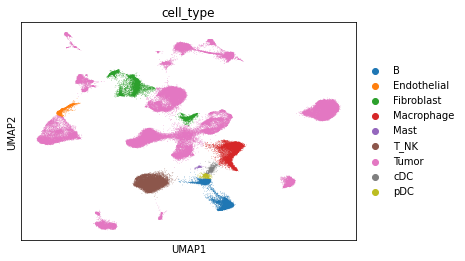

In [10]:
sc.pl.umap(gene_activity, color='cell_type')

In [12]:
train, rest = balancedish_training_generator(peaks, 'cell_type', n_per_cell_type=500, split=1.)
train

View of AnnData object with n_obs × n_vars = 3901 × 257715
    obs: 'orig.ident', 'nCount_peaks', 'nFeature_peaks', 'total', 'duplicate', 'chimeric', 'unmapped', 'lowmapq', 'mitochondrial', 'passed_filters', 'cell_id', 'is__cell_barcode', 'TSS_fragments', 'DNase_sensitive_region_fragments', 'enhancer_region_fragments', 'promoter_region_fragments', 'on_target_fragments', 'blacklist_region_fragments', 'peak_region_fragments', 'peak_region_cutsites', 'nucleosome_signal', 'nucleosome_percentile', 'TSS.enrichment', 'TSS.percentile', 'pct_reads_in_peaks', 'blacklist_ratio', 'high.tss', 'nucleosome_group', 'peaks_snn_res.0.8', 'seurat_clusters', 'nCount_RNA', 'nFeature_RNA', 'predicted.id', 'prediction.score.Tumor', 'prediction.score.Fibroblast', 'prediction.score.Endothelial', 'prediction.score.NK', 'prediction.score.CD4_T', 'prediction.score.Macrophage', 'prediction.score.Treg', 'prediction.score.CD8_T', 'prediction.score.Unknown', 'prediction.score.Mast', 'prediction.score.max', 'nCount_pe

In [13]:
## train module
pds = PollockDataset(train.copy(), cell_type_key='cell_type', n_per_cell_type=200,
                    oversample=True, dataset_type='training', )

2020-11-19 15:31:38,130 input dataset shape: (3901, 257715)
2020-11-19 15:31:38,131 possible cell types: ['B', 'Endothelial', 'Fibroblast', 'Macrophage', 'Mast', 'T_NK', 'Tumor', 'cDC', 'pDC']
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


In [14]:
pm = PollockModel(pds.cell_types, pds.train_adata.shape[1], alpha=.0001, latent_dim=25, )

In [15]:
pm.fit(pds, epochs=20)

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2020-11-19 15:32:30,978 epoch: 1, train loss: 215.4899139404297, val loss: 197.53146362304688
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2020-11-19 15:33:03,128 epoch: 2, train loss: 204.53475952148438, val loss: 194.80511474609375
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2020-11-19 15:33:35,307 epoch: 3, train loss: 198.90866088867188, val loss: 193.8463134765625
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dty

In [16]:
pm.save(pds, module_fp)

metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.


Text(32.09375, 0.5, 'Groundtruth')

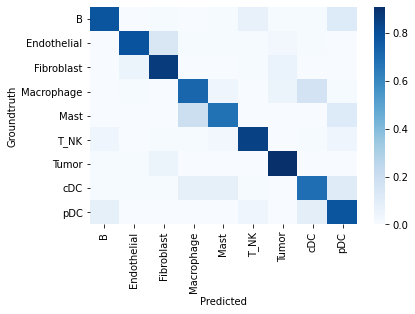

In [17]:
confusion_matrix = pd.DataFrame(data=pm.summary['validation']['confusion_matrix'], columns=pm.class_names,
                  index=pm.class_names)
sns.heatmap(confusion_matrix, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Groundtruth')

In [21]:
predictions = predict_from_anndata(peaks.copy(), module_fp, adata_batch_size=2500)
predictions

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2020-11-19 16:05:05,984 0 genes in training set are missing from prediction set
2020-11-19 16:05:09,999 starting batch 1 of 37
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2020-11-19 16:05:10,223 0 genes in training set are missing from prediction set
2020-11-19 16:05:57,687 starting batch 2 of 37
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2020-11-19 16:05:57,980 0 genes in training set are missing from prediction set
2020-11-19 16:06:43,590 starting batch 3 of 37
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2020-11-19 16:06:43,924 0 genes in training set are missing from prediction set
2020-11-19 16:07:29,148 starting batch 4 of 37
is_categorical is deprecated and will be removed in a future version.  Use i

2020-11-19 16:31:18,414 0 genes in training set are missing from prediction set
2020-11-19 16:32:03,639 starting batch 36 of 37
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2020-11-19 16:32:04,014 0 genes in training set are missing from prediction set
2020-11-19 16:32:49,243 starting batch 37 of 37
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2020-11-19 16:32:49,497 0 genes in training set are missing from prediction set


predicted_cell_type  \
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_GGCACGTT...         Endothelial   
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_TTATGTCC...          Fibroblast   
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_GACTAGTT...          Fibroblast   
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_GGTCATAT...         Endothelial   
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_AGCTGATC...          Fibroblast   
...                                                                ...   
TWCE-HT217B1-XBa1_TGGCAATGTTACCCAA-1                             Tumor   
TWCE-HT217B1-XBa1_ACCGAATGTGAGTAAT-1                             Tumor   
TWCE-HT217B1-XBa1_TAAACCGTCTGATCCC-1                             Tumor   
TWCE-HT217B1-XBa1_ACCGGGTTCTCAGATG-1                             Tumor   
TWCE-HT217B1-XBa1_GCATGATAGTCAACTC-1                        Macrophage   

                                                    cell_type_probability  \
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_GGCACGTT...                   0.31   
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_TTATGTCC...                   0.34   
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_GACTAGTT...                   0.36   
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_GGTCATAT...                   0.40   
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_AGCTGATC...                   0.42   
...                                                                   ...   
TWCE-HT217B1-XBa1_TGGCAATGTTACCCAA-1                                 0.68   
TWCE-HT217B1-XBa1_ACCGAATGTGAGTAAT-1                                 0.50   
TWCE-HT217B1-XBa1_TAAACCGTCTGATCCC-1                                 0.81   
TWCE-HT217B1-XBa1_ACCGGGTTCTCAGATG-1                                 0.74   
TWCE-HT217B1-XBa1_GCATGATAGTCAACTC-1                                 0.88   

                                                    probability_B  \
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_GGCACGTT...           0.01   
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_TTATGTCC...           0.01   
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_GACTAGTT...           0.00   
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_GGTCATAT...           0.01   
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_AGCTGATC...           0.00   
...                                                           ...   
TWCE-HT217B1-XBa1_TGGCAATGTTACCCAA-1                         0.02   
TWCE-HT217B1-XBa1_ACCGAATGTGAGTAAT-1                         0.03   
TWCE-HT217B1-XBa1_TAAACCGTCTGATCCC-1                         0.00   
TWCE-HT217B1-XBa1_ACCGGGTTCTCAGATG-1                         0.00   
TWCE-HT217B1-XBa1_GCATGATAGTCAACTC-1                         0.01   

                                                    probability_Endothelial  \
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_GGCACGTT...                     0.31   
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_TTATGTCC...                     0.21   
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_GACTAGTT...                     0.30   
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_GGTCATAT...                     0.40   
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_AGCTGATC...                     0.22   
...                                                                     ...   
TWCE-HT217B1-XBa1_TGGCAATGTTACCCAA-1                                   0.14   
TWCE-HT217B1-XBa1_ACCGAATGTGAGTAAT-1                                   0.29   
TWCE-HT217B1-XBa1_TAAACCGTCTGATCCC-1                                   0.12   
TWCE-HT217B1-XBa1_ACCGGGTTCTCAGATG-1                                   0.16   
TWCE-HT217B1-XBa1_GCATGATAGTCAACTC-1                                   0.01   

                                                    probability_Fibroblast  \
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_GGCACGTT...                    0.31   
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_TTATGTCC...                    0.34   
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_GACTAGTT...                    0.36   
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_GGTCATAT...                    0.24   
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_AGCTGATC...                   

In [22]:
embeddings = embed_from_anndata(peaks.copy(), module_fp, adata_batch_size=2500)
embeddings

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2020-11-19 16:44:09,790 0 genes in training set are missing from prediction set
2020-11-19 16:44:13,786 starting batch 1 of 37
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2020-11-19 16:44:14,023 0 genes in training set are missing from prediction set
2020-11-19 16:44:59,223 starting batch 2 of 37
2020-11-19 16:44:59,976 0 genes in training set are missing from prediction set
2020-11-19 16:45:44,487 starting batch 3 of 37
2020-11-19 16:45:44,764 0 genes in training set are missing from prediction set
2020-11-19 16:46:26,487 starting batch 4 of 37
2020-11-19 16:46:26,763 0 genes in training set are missing from prediction set
2020-11-19 16:47:08,611 starting batch 5 of 37
2020-11-19 16:47:08,900 0 genes in training set are missing from prediction set
2020-11-19 16:47:51,118 starting batch 6 of 37
2020-11-19 16:47:51,383 0 gene

CELL_EMBEDDING_1  \
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_GGCACGTT...        -14.155066   
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_TTATGTCC...        -24.698057   
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_GACTAGTT...        -13.806851   
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_GGTCATAT...        -12.872599   
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_AGCTGATC...         -9.475371   
...                                                              ...   
TWCE-HT217B1-XBa1_TGGCAATGTTACCCAA-1                       -9.774650   
TWCE-HT217B1-XBa1_ACCGAATGTGAGTAAT-1                      -11.772839   
TWCE-HT217B1-XBa1_TAAACCGTCTGATCCC-1                       -7.939884   
TWCE-HT217B1-XBa1_ACCGGGTTCTCAGATG-1                      -10.953057   
TWCE-HT217B1-XBa1_GCATGATAGTCAACTC-1                       -4.057166   

                                                    CELL_EMBEDDING_2  \
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_GGCACGTT...          1.154276   
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_TTATGTCC...          3.281558   
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_GACTAGTT...          0.442272   
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_GGTCATAT...          0.186910   
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_AGCTGATC...          0.236185   
...                                                              ...   
TWCE-HT217B1-XBa1_TGGCAATGTTACCCAA-1                        1.900501   
TWCE-HT217B1-XBa1_ACCGAATGTGAGTAAT-1                        0.832814   
TWCE-HT217B1-XBa1_TAAACCGTCTGATCCC-1                        0.842030   
TWCE-HT217B1-XBa1_ACCGGGTTCTCAGATG-1                       -0.246464   
TWCE-HT217B1-XBa1_GCATGATAGTCAACTC-1                        0.038547   

                                                    CELL_EMBEDDING_3  \
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_GGCACGTT...          3.096340   
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_TTATGTCC...         10.141581   
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_GACTAGTT...          3.330022   
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_GGTCATAT...          3.241900   
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_AGCTGATC...          1.919966   
...                                                              ...   
TWCE-HT217B1-XBa1_TGGCAATGTTACCCAA-1                       12.853101   
TWCE-HT217B1-XBa1_ACCGAATGTGAGTAAT-1                       11.945949   
TWCE-HT217B1-XBa1_TAAACCGTCTGATCCC-1                        9.701691   
TWCE-HT217B1-XBa1_ACCGGGTTCTCAGATG-1                       13.508752   
TWCE-HT217B1-XBa1_GCATGATAGTCAACTC-1                        1.005225   

                                                    CELL_EMBEDDING_4  \
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_GGCACGTT...          3.486043   
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_TTATGTCC...          9.242572   
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_GACTAGTT...          2.952839   
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_GGTCATAT...          3.727632   
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_AGCTGATC...          1.876207   
...                                                              ...   
TWCE-HT217B1-XBa1_TGGCAATGTTACCCAA-1                        5.292724   
TWCE-HT217B1-XBa1_ACCGAATGTGAGTAAT-1                        4.786926   
TWCE-HT217B1-XBa1_TAAACCGTCTGATCCC-1                        3.906399   
TWCE-HT217B1-XBa1_ACCGGGTTCTCAGATG-1                        5.517972   
TWCE-HT217B1-XBa1_GCATGATAGTCAACTC-1                        0.554065   

                                                    CELL_EMBEDDING_5  \
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_GGCACGTT...         -6.603269   
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_TTATGTCC...        -13.025805   
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_GACTAGTT...         -7.087758   
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_GGTCATAT...         -7.067279   
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_AGCTGATC...         -4.418830   
...                                                              ...   
TWCE-HT217B1-XBa1_TGGCAATGTTACCCAA-1                       -5.949053   
TWCE-HT217B1-XBa

In [23]:
from sklearn.preprocessing import StandardScaler
X = umap.UMAP().fit_transform(StandardScaler().fit_transform(embeddings.values))

In [24]:
pd.merge(peaks.obs, predictions, left_index=True, right_index=True)

orig.ident  \
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_GGCACGTT...  TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2   
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_TTATGTCC...  TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2   
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_GACTAGTT...  TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2   
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_GGTCATAT...  TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2   
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_AGCTGATC...  TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2   
...                                                                                    ...   
TWCE-HT217B1-XBa1_TGGCAATGTTACCCAA-1                                     TWCE-HT217B1-XBa1   
TWCE-HT217B1-XBa1_ACCGAATGTGAGTAAT-1                                     TWCE-HT217B1-XBa1   
TWCE-HT217B1-XBa1_TAAACCGTCTGATCCC-1                                     TWCE-HT217B1-XBa1   
TWCE-HT217B1-XBa1_ACCGGGTTCTCAGATG-1                                     TWCE-HT217B1-XBa1   
TWCE-HT217B1-XBa1_GCATGATAGTCAACTC-1                                                   NaN   

                                                    nCount_peaks  \
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_GGCACGTT...       13904.0   
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_TTATGTCC...       26168.0   
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_GACTAGTT...       13615.0   
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_GGTCATAT...       13961.0   
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_AGCTGATC...        9587.0   
...                                                          ...   
TWCE-HT217B1-XBa1_TGGCAATGTTACCCAA-1                     11468.0   
TWCE-HT217B1-XBa1_ACCGAATGTGAGTAAT-1                     12638.0   
TWCE-HT217B1-XBa1_TAAACCGTCTGATCCC-1                      8954.0   
TWCE-HT217B1-XBa1_ACCGGGTTCTCAGATG-1                     11919.0   
TWCE-HT217B1-XBa1_GCATGATAGTCAACTC-1                      3513.0   

                                                    nFeature_peaks  total  \
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_GGCACGTT...            5926  21256   
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_TTATGTCC...            9775  69841   
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_GACTAGTT...            5758  21679   
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_GGTCATAT...            5895  34816   
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_AGCTGATC...            4317  18547   
...                                                            ...    ...   
TWCE-HT217B1-XBa1_TGGCAATGTTACCCAA-1                          4724  16489   
TWCE-HT217B1-XBa1_ACCGAATGTGAGTAAT-1                          5180  33558   
TWCE-HT217B1-XBa1_TAAACCGTCTGATCCC-1                          3942  14667   
TWCE-HT217B1-XBa1_ACCGGGTTCTCAGATG-1                          4908  22169   
TWCE-HT217B1-XBa1_GCATGATAGTCAACTC-1                          1658   4849   

                                                    duplicate  chimeric  \
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_GGCACGTT...       3308       229   
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_TTATGTCC...       8931       723   
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_GACTAGTT...       3016       223   
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_GGTCATAT...       4732       331   
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_AGCTGATC...       2663       169   
...                                                       ...       ...   
TWCE-HT217B1-XBa1_TGGCAATGTTACCCAA-1                     4726       128   
TWCE-HT217B1-XBa1_ACCGAATGTGAGTAAT-1                     7085       313   
TWCE-HT217B1-XBa1_TAAACCGTCTGATCCC-1                     3092       131   
TWCE-HT217B1-XBa1_ACCGGGTTCTCAGATG-1                     4665       217   
TWCE-HT217B1-XBa1_GCATGATAGTCAACTC-1                      973        24   

                                                    unmapped  lowmapq  \
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_GGCACGTT...       200     2049   
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_TTATGTCC...      1080     8301   
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_GACTAGTT...       182     1991   
TWCE-HT-027-B-Sl

In [30]:
peaks.obs = pd.merge(peaks.obs, predictions, left_index=True, right_index=True)
peaks.obsm['X_embedding'] = embeddings.values
peaks.obsm['X_umap_embedding'] = X

gene_activity.obs = pd.merge(gene_activity.obs, predictions, left_index=True, right_index=True)
gene_activity.obsm['X_embedding'] = embeddings.values
gene_activity.obsm['X_umap_embedding'] = X

motif_access.obs = pd.merge(motif_access.obs, predictions, left_index=True, right_index=True)
motif_access.obsm['X_embedding'] = embeddings.values
motif_access.obsm['X_umap_embedding'] = X

In [33]:
colors = ['cell_type', 'orig.ident', 'cell_type_probability']

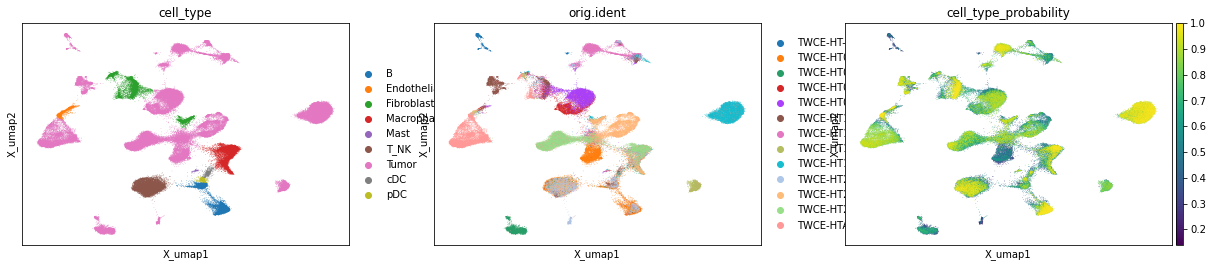

In [34]:
sc.pl.embedding(peaks, basis='X_umap', color=colors,)

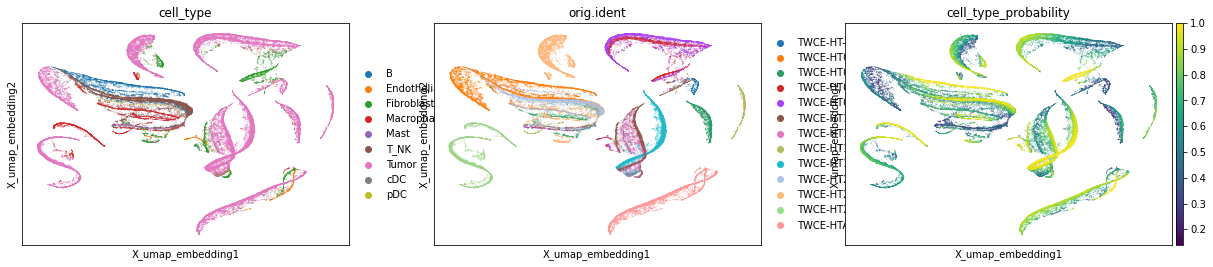

In [35]:
sc.pl.embedding(peaks, basis='X_umap_embedding', color=colors)

In [36]:
train = motif_access.copy()

In [37]:
## train module
pds = PollockDataset(train.copy(), cell_type_key='cell_type', n_per_cell_type=200,
                    oversample=True, dataset_type='training', )

2020-11-19 17:31:06,951 input dataset shape: (90757, 633)
2020-11-19 17:31:06,956 possible cell types: ['B', 'Endothelial', 'Fibroblast', 'Macrophage', 'Mast', 'T_NK', 'Tumor', 'cDC', 'pDC']
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


In [38]:
pm = PollockModel(pds.cell_types, pds.train_adata.shape[1], alpha=.0001, latent_dim=25, )

In [39]:
pm.fit(pds, epochs=20)

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2020-11-19 17:31:18,689 epoch: 1, train loss: 8.43614673614502, val loss: 13.378483772277832
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2020-11-19 17:31:20,176 epoch: 2, train loss: 6.350473880767822, val loss: 10.038518905639648
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2020-11-19 17:31:21,639 epoch: 3, train loss: 5.710202693939209, val loss: 7.261327743530273
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype 

In [42]:
pm.save(pds, module_fp + '_motif_accessability')

metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.


Text(32.09375, 0.5, 'Groundtruth')

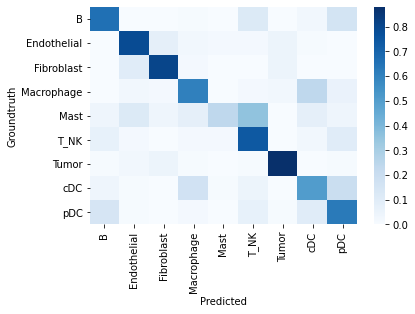

In [43]:
confusion_matrix = pd.DataFrame(data=pm.summary['validation']['confusion_matrix'], columns=pm.class_names,
                  index=pm.class_names)
sns.heatmap(confusion_matrix, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Groundtruth')

In [44]:
predictions = predict_from_anndata(motif_access.copy(), module_fp + '_motif_accessability', adata_batch_size=10000)
predictions

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2020-11-19 17:38:50,234 0 genes in training set are missing from prediction set
2020-11-19 17:38:50,350 starting batch 1 of 10
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2020-11-19 17:38:50,410 0 genes in training set are missing from prediction set
2020-11-19 17:38:51,022 starting batch 2 of 10
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2020-11-19 17:38:51,098 0 genes in training set are missing from prediction set
2020-11-19 17:38:51,724 starting batch 3 of 10
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2020-11-19 17:38:51,810 0 genes in training set are missing from prediction set
2020-11-19 17:38:53,193 starting batch 4 of 10
is_categorical is deprecated and will be removed in a future version.  Use i

predicted_cell_type  \
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_GGCACGTT...                   B   
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_TTATGTCC...               Tumor   
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_GACTAGTT...               Tumor   
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_GGTCATAT...               Tumor   
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_AGCTGATC...               Tumor   
...                                                                ...   
TWCE-HT217B1-XBa1_TGGCAATGTTACCCAA-1                             Tumor   
TWCE-HT217B1-XBa1_ACCGAATGTGAGTAAT-1                             Tumor   
TWCE-HT217B1-XBa1_TAAACCGTCTGATCCC-1                             Tumor   
TWCE-HT217B1-XBa1_ACCGGGTTCTCAGATG-1                             Tumor   
TWCE-HT217B1-XBa1_GCATGATAGTCAACTC-1                        Macrophage   

                                                    cell_type_probability  \
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_GGCACGTT...                   0.32   
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_TTATGTCC...                   0.86   
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_GACTAGTT...                   0.48   
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_GGTCATAT...                   0.70   
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_AGCTGATC...                   0.55   
...                                                                   ...   
TWCE-HT217B1-XBa1_TGGCAATGTTACCCAA-1                                 0.94   
TWCE-HT217B1-XBa1_ACCGAATGTGAGTAAT-1                                 0.54   
TWCE-HT217B1-XBa1_TAAACCGTCTGATCCC-1                                 0.94   
TWCE-HT217B1-XBa1_ACCGGGTTCTCAGATG-1                                 0.92   
TWCE-HT217B1-XBa1_GCATGATAGTCAACTC-1                                 0.43   

                                                    probability_B  \
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_GGCACGTT...           0.32   
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_TTATGTCC...           0.01   
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_GACTAGTT...           0.03   
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_GGTCATAT...           0.00   
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_AGCTGATC...           0.05   
...                                                           ...   
TWCE-HT217B1-XBa1_TGGCAATGTTACCCAA-1                         0.01   
TWCE-HT217B1-XBa1_ACCGAATGTGAGTAAT-1                         0.00   
TWCE-HT217B1-XBa1_TAAACCGTCTGATCCC-1                         0.00   
TWCE-HT217B1-XBa1_ACCGGGTTCTCAGATG-1                         0.00   
TWCE-HT217B1-XBa1_GCATGATAGTCAACTC-1                         0.05   

                                                    probability_Endothelial  \
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_GGCACGTT...                     0.05   
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_TTATGTCC...                     0.05   
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_GACTAGTT...                     0.16   
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_GGTCATAT...                     0.12   
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_AGCTGATC...                     0.12   
...                                                                     ...   
TWCE-HT217B1-XBa1_TGGCAATGTTACCCAA-1                                   0.01   
TWCE-HT217B1-XBa1_ACCGAATGTGAGTAAT-1                                   0.20   
TWCE-HT217B1-XBa1_TAAACCGTCTGATCCC-1                                   0.01   
TWCE-HT217B1-XBa1_ACCGGGTTCTCAGATG-1                                   0.00   
TWCE-HT217B1-XBa1_GCATGATAGTCAACTC-1                                   0.00   

                                                    probability_Fibroblast  \
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_GGCACGTT...                    0.08   
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_TTATGTCC...                    0.06   
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_GACTAGTT...                    0.30   
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_GGTCATAT...                    0.16   
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_AGCTGATC...                   

In [45]:
embeddings = embed_from_anndata(motif_access.copy(), module_fp + '_motif_accessability', adata_batch_size=10000)
embeddings

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2020-11-19 17:39:32,761 0 genes in training set are missing from prediction set
2020-11-19 17:39:32,868 starting batch 1 of 10
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2020-11-19 17:39:32,927 0 genes in training set are missing from prediction set
2020-11-19 17:39:33,299 starting batch 2 of 10
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2020-11-19 17:39:33,376 0 genes in training set are missing from prediction set
2020-11-19 17:39:33,881 starting batch 3 of 10
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2020-11-19 17:39:34,281 0 genes in training set are missing from prediction set
2020-11-19 17:39:34,776 starting batch 4 of 10
is_categorical is deprecated and will be removed in a future version.  Use i

CELL_EMBEDDING_1  \
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_GGCACGTT...          0.456102   
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_TTATGTCC...          0.060562   
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_GACTAGTT...          0.688331   
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_GGTCATAT...          0.070533   
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_AGCTGATC...          0.133245   
...                                                              ...   
TWCE-HT217B1-XBa1_TGGCAATGTTACCCAA-1                       -0.145644   
TWCE-HT217B1-XBa1_ACCGAATGTGAGTAAT-1                       -0.301775   
TWCE-HT217B1-XBa1_TAAACCGTCTGATCCC-1                        0.247826   
TWCE-HT217B1-XBa1_ACCGGGTTCTCAGATG-1                        0.225203   
TWCE-HT217B1-XBa1_GCATGATAGTCAACTC-1                       -0.766125   

                                                    CELL_EMBEDDING_2  \
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_GGCACGTT...          0.448909   
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_TTATGTCC...         -0.657945   
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_GACTAGTT...         -0.408965   
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_GGTCATAT...         -2.271092   
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_AGCTGATC...         -0.941274   
...                                                              ...   
TWCE-HT217B1-XBa1_TGGCAATGTTACCCAA-1                       -3.097433   
TWCE-HT217B1-XBa1_ACCGAATGTGAGTAAT-1                       -3.367898   
TWCE-HT217B1-XBa1_TAAACCGTCTGATCCC-1                       -1.616946   
TWCE-HT217B1-XBa1_ACCGGGTTCTCAGATG-1                       -2.650696   
TWCE-HT217B1-XBa1_GCATGATAGTCAACTC-1                        1.160900   

                                                    CELL_EMBEDDING_3  \
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_GGCACGTT...         -1.207081   
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_TTATGTCC...         -0.692993   
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_GACTAGTT...         -0.375613   
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_GGTCATAT...         -0.852402   
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_AGCTGATC...         -0.546383   
...                                                              ...   
TWCE-HT217B1-XBa1_TGGCAATGTTACCCAA-1                       -0.878680   
TWCE-HT217B1-XBa1_ACCGAATGTGAGTAAT-1                       -1.397760   
TWCE-HT217B1-XBa1_TAAACCGTCTGATCCC-1                       -0.330547   
TWCE-HT217B1-XBa1_ACCGGGTTCTCAGATG-1                       -0.264953   
TWCE-HT217B1-XBa1_GCATGATAGTCAACTC-1                       -1.858021   

                                                    CELL_EMBEDDING_4  \
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_GGCACGTT...          0.859508   
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_TTATGTCC...          0.218763   
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_GACTAGTT...          0.997166   
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_GGTCATAT...         -0.290453   
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_AGCTGATC...          0.363552   
...                                                              ...   
TWCE-HT217B1-XBa1_TGGCAATGTTACCCAA-1                        0.051821   
TWCE-HT217B1-XBa1_ACCGAATGTGAGTAAT-1                       -0.386671   
TWCE-HT217B1-XBa1_TAAACCGTCTGATCCC-1                        0.209850   
TWCE-HT217B1-XBa1_ACCGGGTTCTCAGATG-1                        0.084739   
TWCE-HT217B1-XBa1_GCATGATAGTCAACTC-1                       -0.099394   

                                                    CELL_EMBEDDING_5  \
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_GGCACGTT...         -0.487341   
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_TTATGTCC...          1.530890   
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_GACTAGTT...          0.699507   
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_GGTCATAT...          2.058195   
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_AGCTGATC...          0.658517   
...                                                              ...   
TWCE-HT217B1-XBa1_TGGCAATGTTACCCAA-1                        2.870019   
TWCE-HT217B1-XBa

In [46]:
from sklearn.preprocessing import StandardScaler
X = umap.UMAP().fit_transform(StandardScaler().fit_transform(embeddings.values))

In [49]:
pd.merge(peaks.obs, predictions, left_index=True, right_index=True)

orig.ident  \
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_GGCACGTT...  TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2   
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_TTATGTCC...  TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2   
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_GACTAGTT...  TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2   
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_GGTCATAT...  TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2   
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_AGCTGATC...  TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2   
...                                                                                    ...   
TWCE-HT217B1-XBa1_TGGCAATGTTACCCAA-1                                     TWCE-HT217B1-XBa1   
TWCE-HT217B1-XBa1_ACCGAATGTGAGTAAT-1                                     TWCE-HT217B1-XBa1   
TWCE-HT217B1-XBa1_TAAACCGTCTGATCCC-1                                     TWCE-HT217B1-XBa1   
TWCE-HT217B1-XBa1_ACCGGGTTCTCAGATG-1                                     TWCE-HT217B1-XBa1   
TWCE-HT217B1-XBa1_GCATGATAGTCAACTC-1                                                   NaN   

                                                    nCount_peaks  \
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_GGCACGTT...       13904.0   
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_TTATGTCC...       26168.0   
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_GACTAGTT...       13615.0   
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_GGTCATAT...       13961.0   
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_AGCTGATC...        9587.0   
...                                                          ...   
TWCE-HT217B1-XBa1_TGGCAATGTTACCCAA-1                     11468.0   
TWCE-HT217B1-XBa1_ACCGAATGTGAGTAAT-1                     12638.0   
TWCE-HT217B1-XBa1_TAAACCGTCTGATCCC-1                      8954.0   
TWCE-HT217B1-XBa1_ACCGGGTTCTCAGATG-1                     11919.0   
TWCE-HT217B1-XBa1_GCATGATAGTCAACTC-1                      3513.0   

                                                    nFeature_peaks  total  \
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_GGCACGTT...            5926  21256   
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_TTATGTCC...            9775  69841   
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_GACTAGTT...            5758  21679   
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_GGTCATAT...            5895  34816   
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_AGCTGATC...            4317  18547   
...                                                            ...    ...   
TWCE-HT217B1-XBa1_TGGCAATGTTACCCAA-1                          4724  16489   
TWCE-HT217B1-XBa1_ACCGAATGTGAGTAAT-1                          5180  33558   
TWCE-HT217B1-XBa1_TAAACCGTCTGATCCC-1                          3942  14667   
TWCE-HT217B1-XBa1_ACCGGGTTCTCAGATG-1                          4908  22169   
TWCE-HT217B1-XBa1_GCATGATAGTCAACTC-1                          1658   4849   

                                                    duplicate  chimeric  \
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_GGCACGTT...       3308       229   
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_TTATGTCC...       8931       723   
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_GACTAGTT...       3016       223   
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_GGTCATAT...       4732       331   
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_AGCTGATC...       2663       169   
...                                                       ...       ...   
TWCE-HT217B1-XBa1_TGGCAATGTTACCCAA-1                     4726       128   
TWCE-HT217B1-XBa1_ACCGAATGTGAGTAAT-1                     7085       313   
TWCE-HT217B1-XBa1_TAAACCGTCTGATCCC-1                     3092       131   
TWCE-HT217B1-XBa1_ACCGGGTTCTCAGATG-1                     4665       217   
TWCE-HT217B1-XBa1_GCATGATAGTCAACTC-1                      973        24   

                                                    unmapped  lowmapq  \
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_GGCACGTT...       200     2049   
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_TTATGTCC...      1080     8301   
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_GACTAGTT...       182     1991   
TWCE-HT-027-B-Sl

In [50]:
peaks.obs = pd.merge(peaks.obs, predictions, left_index=True, right_index=True)
peaks.obsm['X_embedding'] = embeddings.values
peaks.obsm['X_umap_embedding'] = X

gene_activity.obs = pd.merge(gene_activity.obs, predictions, left_index=True, right_index=True)
gene_activity.obsm['X_embedding'] = embeddings.values
gene_activity.obsm['X_umap_embedding'] = X

motif_access.obs = pd.merge(motif_access.obs, predictions, left_index=True, right_index=True)
motif_access.obsm['X_embedding'] = embeddings.values
motif_access.obsm['X_umap_embedding'] = X

In [51]:
colors = ['cell_type', 'orig.ident', 'cell_type_probability']

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
... storing 'predicted_cell_type' as categorical


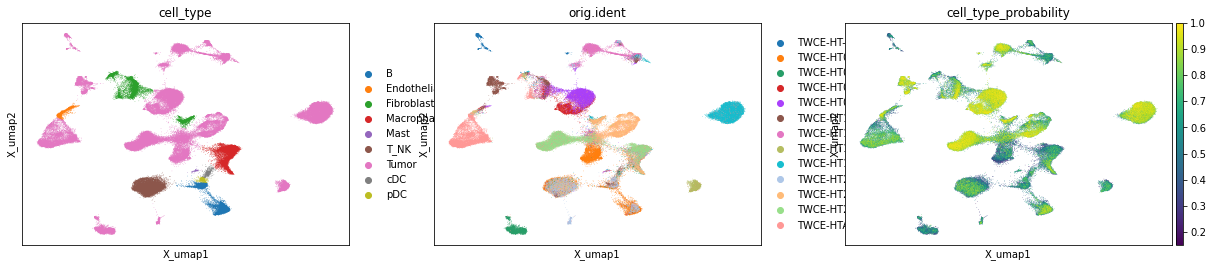

In [52]:
sc.pl.embedding(motif_access, basis='X_umap', color=colors,)

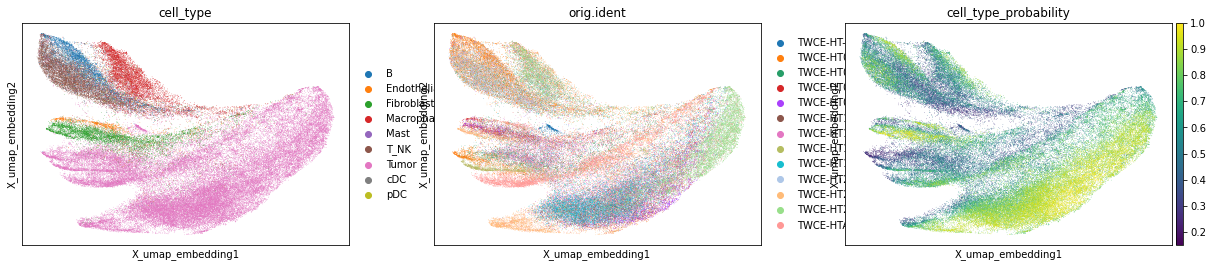

In [53]:
sc.pl.embedding(motif_access, basis='X_umap_embedding', color=colors)

In [54]:
explain, rest = balancedish_training_generator(motif_access, 'cell_type', n_per_cell_type=100)
background, _ = balancedish_training_generator(rest, 'cell_type', n_per_cell_type=15)
explain.shape

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


(861, 633)

In [55]:
w = explain_predictions(explain.copy(), background.copy(), module_fp + '_motif_accessability')
w

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2020-11-19 18:08:54,969 0 genes in training set are missing from prediction set
2020-11-19 18:08:55,120 starting batch 1 of 1
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2020-11-19 18:08:55,191 0 genes in training set are missing from prediction set
2020-11-19 18:08:55,313 0 genes in training set are missing from prediction set
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


MA0030.1  MA0031.1  \
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_TTACTTGA...  0.000600  0.002948   
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_GGGTCTGC...  0.000164  0.001893   
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_GATGATCT...  0.000836  0.000395   
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_TAGGTCAC...  0.000058  0.000549   
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_CAGTGTAT...  0.000953  0.000821   
...                                                      ...       ...   
TWCE-HT217B1-XBa1_TGATGCACATTCACGA-1                0.003476  0.001592   
TWCE-HT217B1-XBa1_CAGCCTTCATTCACCC-1                0.005858  0.000519   
TWCE-HT217B1-XBa1_GATGGCCTCTCCACTG-1                0.001819  0.000221   
TWCE-HT217B1-XBa1_GGAACTTTCGGATGTT-1                0.002028  0.000128   
TWCE-HT217B1-XBa1_TTGCGAATCATTCTCA-1                0.006230  0.000974   

                                                    MA0051.1  MA0057.1  \
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_TTACTTGA...  0.000297  0.000370   
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_GGGTCTGC...  0.001439  0.000835   
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_GATGATCT...  0.000891  0.000058   
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_TAGGTCAC...  0.000134  0.000083   
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_CAGTGTAT...  0.001169  0.002070   
...                                                      ...       ...   
TWCE-HT217B1-XBa1_TGATGCACATTCACGA-1                0.001747  0.000155   
TWCE-HT217B1-XBa1_CAGCCTTCATTCACCC-1                0.005297  0.000001   
TWCE-HT217B1-XBa1_GATGGCCTCTCCACTG-1                0.003041  0.000569   
TWCE-HT217B1-XBa1_GGAACTTTCGGATGTT-1                0.001033  0.000317   
TWCE-HT217B1-XBa1_TTGCGAATCATTCTCA-1                0.005416  0.000633   

                                                    MA0059.1  MA0066.1  \
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_TTACTTGA...  0.001382  0.000347   
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_GGGTCTGC...  0.001605  0.000765   
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_GATGATCT...  0.000916  0.000456   
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_TAGGTCAC...  0.000129  0.000105   
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_CAGTGTAT...  0.000049  0.000690   
...                                                      ...       ...   
TWCE-HT217B1-XBa1_TGATGCACATTCACGA-1                0.002990  0.002129   
TWCE-HT217B1-XBa1_CAGCCTTCATTCACCC-1                0.005935  0.003910   
TWCE-HT217B1-XBa1_GATGGCCTCTCCACTG-1                0.003406  0.000796   
TWCE-HT217B1-XBa1_GGAACTTTCGGATGTT-1                0.000579  0.000298   
TWCE-HT217B1-XBa1_TTGCGAATCATTCTCA-1                0.008852  0.003393   

                                                    MA0069.1  MA0070.1  \
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_TTACTTGA...  0.003418  0.000011   
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_GGGTCTGC...  0.000735  0.000012   
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_GATGATCT...  0.000699  0.002012   
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_TAGGTCAC...  0.000182  0.001674   
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_CAGTGTAT...  0.000359  0.000340   
...                                                      ...       ...   
TWCE-HT217B1-XBa1_TGATGCACATTCACGA-1                0.002982  0.000491   
TWCE-HT217B1-XBa1_CAGCCTTCATTCACCC-1                0.000543  0.000341   
TWCE-HT217B1-XBa1_GATGGCCTCTCCACTG-1                0.001563  0.000166   
TWCE-HT217B1-XBa1_GGAACTTTCGGATGTT-1                0.000610  0.001176   
TWCE-HT217B1-XBa1_TTGCGAATCATTCTCA-1                0.002414  0.000287   

                                                    MA0071.1  MA0072.1  ...  \
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_TTACTTGA...  0.000310  0.000228  ...   
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_GGGTCTGC...  0.000167  0.000012  ...   
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_GATGATCT...  0.000443  0.000147  ...   
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_TAGGTCAC...  0.000079  0.000288  ...   
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_CAGTGTAT...  0.000755  0.000846  ...   
...                   

In [56]:
weights = anndata.AnnData(X=w.values, obs=explain.obs.copy())
weights.var.index = w.columns
weights

AnnData object with n_obs × n_vars = 861 × 633
    obs: 'orig.ident', 'nCount_peaks', 'nFeature_peaks', 'total', 'duplicate', 'chimeric', 'unmapped', 'lowmapq', 'mitochondrial', 'passed_filters', 'cell_id', 'is__cell_barcode', 'TSS_fragments', 'DNase_sensitive_region_fragments', 'enhancer_region_fragments', 'promoter_region_fragments', 'on_target_fragments', 'blacklist_region_fragments', 'peak_region_fragments', 'peak_region_cutsites', 'nucleosome_signal', 'nucleosome_percentile', 'TSS.enrichment', 'TSS.percentile', 'pct_reads_in_peaks', 'blacklist_ratio', 'high.tss', 'nucleosome_group', 'peaks_snn_res.0.8', 'seurat_clusters', 'nCount_RNA', 'nFeature_RNA', 'predicted.id', 'prediction.score.Tumor', 'prediction.score.Fibroblast', 'prediction.score.Endothelial', 'prediction.score.NK', 'prediction.score.CD4_T', 'prediction.score.Macrophage', 'prediction.score.Treg', 'prediction.score.CD8_T', 'prediction.score.Unknown', 'prediction.score.Mast', 'prediction.score.max', 'nCount_peaksinters', 

In [57]:
feature_adata = weights.copy()
sc.pp.scale(feature_adata)
sc.pp.neighbors(feature_adata)
sc.pp.pca(feature_adata)

sc.tl.umap(feature_adata)
sc.tl.leiden(feature_adata, resolution=.2)
feature_adata

         Falling back to preprocessing with `sc.pp.pca` and default params.


AnnData object with n_obs × n_vars = 861 × 633
    obs: 'orig.ident', 'nCount_peaks', 'nFeature_peaks', 'total', 'duplicate', 'chimeric', 'unmapped', 'lowmapq', 'mitochondrial', 'passed_filters', 'cell_id', 'is__cell_barcode', 'TSS_fragments', 'DNase_sensitive_region_fragments', 'enhancer_region_fragments', 'promoter_region_fragments', 'on_target_fragments', 'blacklist_region_fragments', 'peak_region_fragments', 'peak_region_cutsites', 'nucleosome_signal', 'nucleosome_percentile', 'TSS.enrichment', 'TSS.percentile', 'pct_reads_in_peaks', 'blacklist_ratio', 'high.tss', 'nucleosome_group', 'peaks_snn_res.0.8', 'seurat_clusters', 'nCount_RNA', 'nFeature_RNA', 'predicted.id', 'prediction.score.Tumor', 'prediction.score.Fibroblast', 'prediction.score.Endothelial', 'prediction.score.NK', 'prediction.score.CD4_T', 'prediction.score.Macrophage', 'prediction.score.Treg', 'prediction.score.CD8_T', 'prediction.score.Unknown', 'prediction.score.Mast', 'prediction.score.max', 'nCount_peaksinters', 

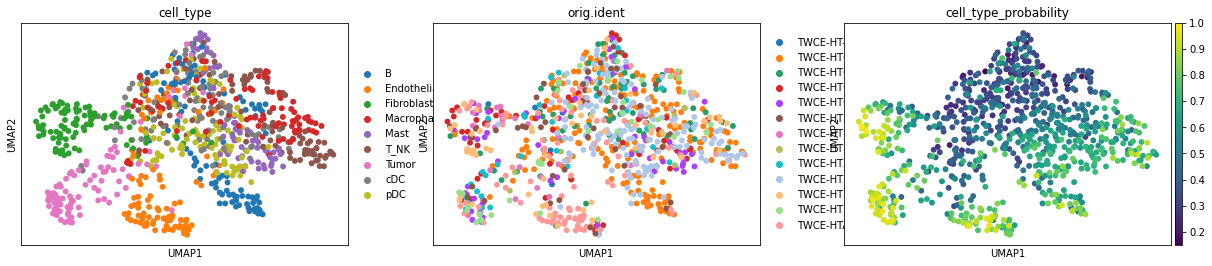

In [58]:
sc.pl.umap(feature_adata, color=colors)

invalid value encountered in log2
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


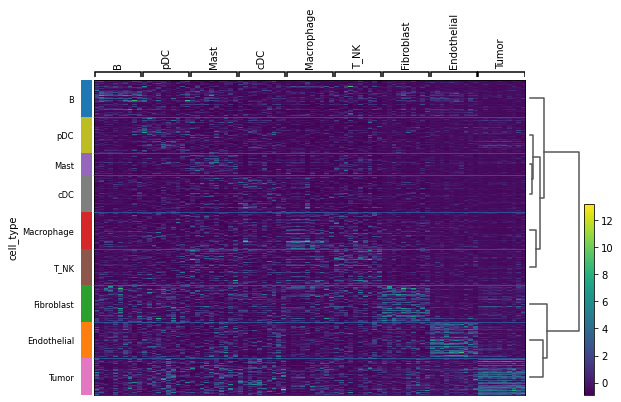

In [60]:
sc.tl.rank_genes_groups(feature_adata, 'cell_type')
sc.pl.rank_genes_groups_heatmap(feature_adata)

categories: B, Endothelial, Fibroblast, etc.
var_group_labels: Tumor


is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


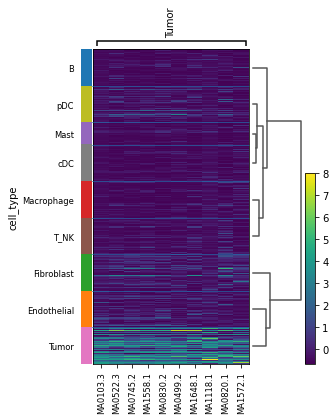

In [61]:
sc.pl.rank_genes_groups_heatmap(feature_adata, groups=['Tumor'])

In [66]:
feature_adata.uns['rank_genes_groups']['names']['Tumor']

array(['MA0103.3', 'MA0522.3', 'MA0745.2', 'MA1558.1', 'MA0830.2',
       'MA0499.2', 'MA1648.1', 'MA1118.1', 'MA0820.1', 'MA1572.1',
       'MA0806.1', 'MA0801.1', 'MA0159.1', 'MA0796.1', 'MA0845.1',
       'MA1597.1', 'MA1114.1', 'MA1567.1', 'MA0138.2', 'MA0670.1',
       'MA0807.1', 'MA1569.1', 'MA1559.1', 'MA0797.1', 'MA1631.1',
       'MA0812.1', 'MA0130.1', 'MA1532.1', 'MA1467.1', 'MA0744.2',
       'MA0811.1', 'MA0671.1', 'MA0815.1', 'MA1571.1', 'MA1579.1',
       'MA1573.1', 'MA1100.2', 'MA1588.1', 'MA0714.1', 'MA1529.1',
       'MA0712.2', 'MA1547.1', 'MA0861.1', 'MA0498.2', 'MA0647.1',
       'MA0805.1', 'MA0465.2', 'MA0665.1', 'MA0760.1', 'MA1103.2',
       'MA1645.1', 'MA1115.1', 'MA1500.1', 'MA0719.1', 'MA0088.2',
       'MA1589.1', 'MA0141.3', 'MA1683.1', 'MA1637.1', 'MA1540.1',
       'MA0887.1', 'MA1513.1', 'MA0003.4', 'MA1484.1', 'MA0098.3',
       'MA0627.2', 'MA1599.1', 'MA0762.1', 'MA1485.1', 'MA0106.3',
       'MA1119.1', 'MA0474.2', 'MA0667.1', 'MA0105.4', 'MA0850

In [ ]:
# MA0745.2 snai2
# MA1558.1 snai1

In [ ]:
feature_adata.uns['rank_genes_groups']['names']['Tumor']

Trying to set attribute `.uns` of view, copying.


invalid value encountered in log2
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


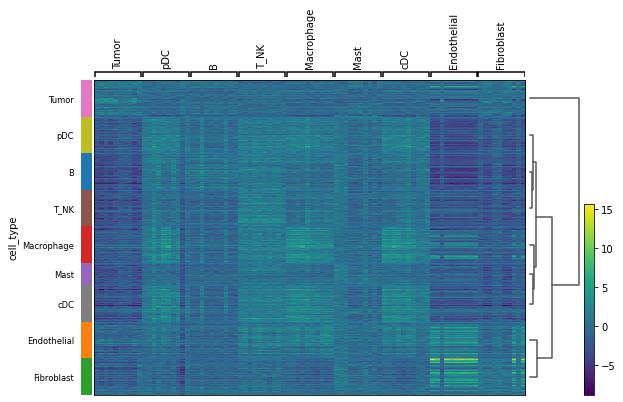

In [68]:
sc.tl.rank_genes_groups(explain, 'cell_type')
sc.pl.rank_genes_groups_heatmap(explain)

In [70]:
filtered = motif_access[motif_access.obs['cell_type']=='Tumor'].copy()
filtered

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


AnnData object with n_obs × n_vars = 60242 × 633
    obs: 'orig.ident', 'nCount_peaks', 'nFeature_peaks', 'total', 'duplicate', 'chimeric', 'unmapped', 'lowmapq', 'mitochondrial', 'passed_filters', 'cell_id', 'is__cell_barcode', 'TSS_fragments', 'DNase_sensitive_region_fragments', 'enhancer_region_fragments', 'promoter_region_fragments', 'on_target_fragments', 'blacklist_region_fragments', 'peak_region_fragments', 'peak_region_cutsites', 'nucleosome_signal', 'nucleosome_percentile', 'TSS.enrichment', 'TSS.percentile', 'pct_reads_in_peaks', 'blacklist_ratio', 'high.tss', 'nucleosome_group', 'peaks_snn_res.0.8', 'seurat_clusters', 'nCount_RNA', 'nFeature_RNA', 'predicted.id', 'prediction.score.Tumor', 'prediction.score.Fibroblast', 'prediction.score.Endothelial', 'prediction.score.NK', 'prediction.score.CD4_T', 'prediction.score.Macrophage', 'prediction.score.Treg', 'prediction.score.CD8_T', 'prediction.score.Unknown', 'prediction.score.Mast', 'prediction.score.max', 'nCount_peaksinters'

In [72]:
explain, rest = balancedish_training_generator(filtered, 'orig.ident', n_per_cell_type=100)
background, _ = balancedish_training_generator(rest, 'orig.ident', n_per_cell_type=8)
explain.shape

(1400, 633)

In [73]:
w = explain_predictions(explain.copy(), background.copy(), module_fp + '_motif_accessability')
w

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2020-11-20 10:20:59,517 0 genes in training set are missing from prediction set
2020-11-20 10:20:59,683 starting batch 1 of 1
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2020-11-20 10:20:59,758 0 genes in training set are missing from prediction set
2020-11-20 10:20:59,905 0 genes in training set are missing from prediction set
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


MA0030.1  MA0031.1  \
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_TGATGCAA...  0.000210  0.000371   
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_TCTAGTTT...  0.000168  0.000381   
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_GCTTTCGA...  0.001160  0.000936   
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_TCACCTGC...  0.000146  0.000112   
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_TGATCAGA...  0.000919  0.000805   
...                                                      ...       ...   
TWCE-HT217B1-XBa1_CTTGCCATCCAACCTC-1                0.000834  0.000459   
TWCE-HT217B1-XBa1_TTGCGGGCAGCTATAC-1                0.000336  0.001771   
TWCE-HT217B1-XBa1_TGATTTCGTCATAGAA-1                0.000094  0.000798   
TWCE-HT217B1-XBa1_ACTACCCCACCTCGTT-1                0.000573  0.000761   
TWCE-HT217B1-XBa1_TTTGGTTTCGTGATAC-1                0.001201  0.000263   

                                                    MA0051.1  MA0057.1  \
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_TGATGCAA...  0.000101  0.000392   
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_TCTAGTTT...  0.002433  0.000456   
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_GCTTTCGA...  0.000190  0.000150   
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_TCACCTGC...  0.000245  0.000024   
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_TGATCAGA...  0.001054  0.000120   
...                                                      ...       ...   
TWCE-HT217B1-XBa1_CTTGCCATCCAACCTC-1                0.004706  0.000505   
TWCE-HT217B1-XBa1_TTGCGGGCAGCTATAC-1                0.001013  0.000669   
TWCE-HT217B1-XBa1_TGATTTCGTCATAGAA-1                0.000558  0.001200   
TWCE-HT217B1-XBa1_ACTACCCCACCTCGTT-1                0.002410  0.000060   
TWCE-HT217B1-XBa1_TTTGGTTTCGTGATAC-1                0.000810  0.000802   

                                                    MA0059.1  MA0066.1  \
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_TGATGCAA...  0.000883  0.000145   
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_TCTAGTTT...  0.000637  0.000508   
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_GCTTTCGA...  0.001314  0.000575   
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_TCACCTGC...  0.000362  0.000406   
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_TGATCAGA...  0.000432  0.000574   
...                                                      ...       ...   
TWCE-HT217B1-XBa1_CTTGCCATCCAACCTC-1                0.003463  0.000595   
TWCE-HT217B1-XBa1_TTGCGGGCAGCTATAC-1                0.005182  0.003162   
TWCE-HT217B1-XBa1_TGATTTCGTCATAGAA-1                0.003122  0.000337   
TWCE-HT217B1-XBa1_ACTACCCCACCTCGTT-1                0.000308  0.001352   
TWCE-HT217B1-XBa1_TTTGGTTTCGTGATAC-1                0.004001  0.003794   

                                                    MA0069.1  MA0070.1  \
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_TGATGCAA...  0.000544  0.000299   
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_TCTAGTTT...  0.000127  0.000076   
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_GCTTTCGA...  0.000531  0.000125   
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_TCACCTGC...  0.000042  0.000121   
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_TGATCAGA...  0.000110  0.000085   
...                                                      ...       ...   
TWCE-HT217B1-XBa1_CTTGCCATCCAACCTC-1                0.000627  0.000143   
TWCE-HT217B1-XBa1_TTGCGGGCAGCTATAC-1                0.004892  0.000044   
TWCE-HT217B1-XBa1_TGATTTCGTCATAGAA-1                0.000764  0.000173   
TWCE-HT217B1-XBa1_ACTACCCCACCTCGTT-1                0.004804  0.000019   
TWCE-HT217B1-XBa1_TTTGGTTTCGTGATAC-1                0.000136  0.000353   

                                                    MA0071.1  MA0072.1  ...  \
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_TGATGCAA...  0.000369  0.000123  ...   
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_TCTAGTTT...  0.000278  0.000020  ...   
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_GCTTTCGA...  0.000427  0.000341  ...   
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_TCACCTGC...  0.000624  0.000330  ...   
TWCE-HT-027-B-Slice1fresh_ATAC-lib1_V2_TGATCAGA...  0.000429  0.000324  ...   
...                   

In [74]:
tumor_weights = anndata.AnnData(X=w.values, obs=explain.obs.copy())
tumor_weights.var.index = w.columns
tumor_weights

AnnData object with n_obs × n_vars = 1400 × 633
    obs: 'orig.ident', 'nCount_peaks', 'nFeature_peaks', 'total', 'duplicate', 'chimeric', 'unmapped', 'lowmapq', 'mitochondrial', 'passed_filters', 'cell_id', 'is__cell_barcode', 'TSS_fragments', 'DNase_sensitive_region_fragments', 'enhancer_region_fragments', 'promoter_region_fragments', 'on_target_fragments', 'blacklist_region_fragments', 'peak_region_fragments', 'peak_region_cutsites', 'nucleosome_signal', 'nucleosome_percentile', 'TSS.enrichment', 'TSS.percentile', 'pct_reads_in_peaks', 'blacklist_ratio', 'high.tss', 'nucleosome_group', 'peaks_snn_res.0.8', 'seurat_clusters', 'nCount_RNA', 'nFeature_RNA', 'predicted.id', 'prediction.score.Tumor', 'prediction.score.Fibroblast', 'prediction.score.Endothelial', 'prediction.score.NK', 'prediction.score.CD4_T', 'prediction.score.Macrophage', 'prediction.score.Treg', 'prediction.score.CD8_T', 'prediction.score.Unknown', 'prediction.score.Mast', 'prediction.score.max', 'nCount_peaksinters',

In [84]:
feature_adata = tumor_weights.copy()
sc.pp.scale(feature_adata)
sc.pp.neighbors(feature_adata)
sc.pp.pca(feature_adata)

sc.tl.umap(feature_adata)
sc.tl.leiden(feature_adata, resolution=1.)
feature_adata

         Falling back to preprocessing with `sc.pp.pca` and default params.


AnnData object with n_obs × n_vars = 1400 × 633
    obs: 'orig.ident', 'nCount_peaks', 'nFeature_peaks', 'total', 'duplicate', 'chimeric', 'unmapped', 'lowmapq', 'mitochondrial', 'passed_filters', 'cell_id', 'is__cell_barcode', 'TSS_fragments', 'DNase_sensitive_region_fragments', 'enhancer_region_fragments', 'promoter_region_fragments', 'on_target_fragments', 'blacklist_region_fragments', 'peak_region_fragments', 'peak_region_cutsites', 'nucleosome_signal', 'nucleosome_percentile', 'TSS.enrichment', 'TSS.percentile', 'pct_reads_in_peaks', 'blacklist_ratio', 'high.tss', 'nucleosome_group', 'peaks_snn_res.0.8', 'seurat_clusters', 'nCount_RNA', 'nFeature_RNA', 'predicted.id', 'prediction.score.Tumor', 'prediction.score.Fibroblast', 'prediction.score.Endothelial', 'prediction.score.NK', 'prediction.score.CD4_T', 'prediction.score.Macrophage', 'prediction.score.Treg', 'prediction.score.CD8_T', 'prediction.score.Unknown', 'prediction.score.Mast', 'prediction.score.max', 'nCount_peaksinters',

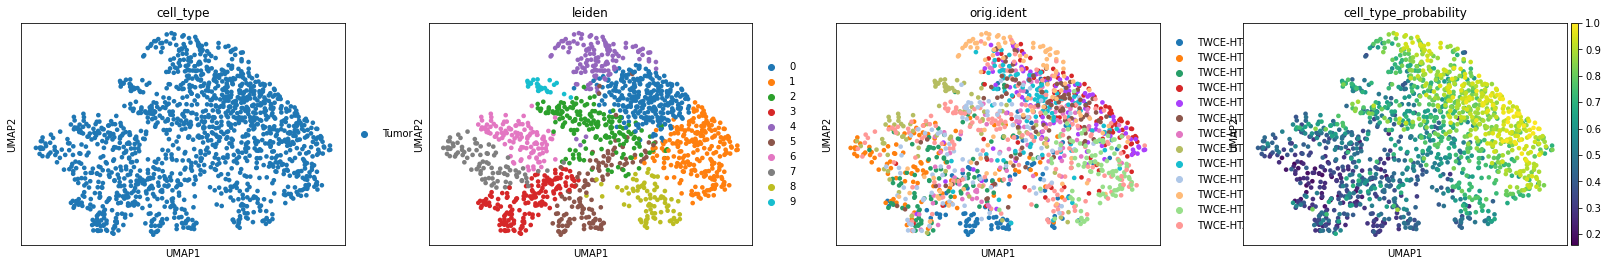

In [85]:
colors = ['cell_type', 'leiden', 'orig.ident', 'cell_type_probability']
sc.pl.umap(feature_adata, color=colors)

invalid value encountered in log2
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


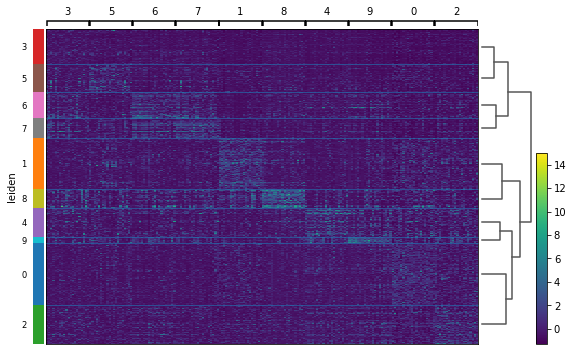

In [109]:
sc.tl.rank_genes_groups(feature_adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups_heatmap(feature_adata, n_genes=20)

In [114]:
motifs = feature_adata.uns['rank_genes_groups']['names']['8']
for m in motifs[:20]: print(motif_df.loc[m, 'gene'])

SREBF1
HAND2
ASCL1(var.2)
NFIC(var.2)
ZBTB26
SOX13
SOX2
HOXB13
ESR2
CREB3L4
VDR
NFIX
SOX8
RUNX3
CDX1
NFIX(var.2)
EOMES
HNF4A(var.2)
SOX18
BHLHE22(var.2)


In [126]:
for g in motif_df['gene']:
    if 'RUN' in g: print(g)

RUNX1
RUNX2
RUNX3


In [129]:
motifs = [motif_df.loc[m, 'gene'] for m in feature_adata.uns['rank_genes_groups']['names']['8']]
ls = ['SOX2', 'NANOG', 'POU5F1', 'POU5F1B', 'RUNX3']
for i, m in enumerate(motifs):
    if m in ls: print(i, m)

6 SOX2
13 RUNX3
183 POU5F1
305 POU5F1B


SREBF1: Among its related pathways are Apoptosis and survival Caspase cascade and mTOR signaling pathway (Pathway Interaction Database).

HAND2: this transcription factor plays an important role in limb and branchial arch development.

ASCL1: Among its related pathways are Neural Crest Differentiation and Embryonic and Induced Pluripotent Stem Cells and Lineage-specific Markers.



In [96]:
motifs = feature_adata.uns['rank_genes_groups']['names']['8']
[motif_df.loc[m] for m in motifs[::-1][:20]]

[gene    JDP2
 Name: MA0655.1, dtype: object,
 gene    FOXG1
 Name: MA0613.1, dtype: object,
 gene    JUN(var.2)
 Name: MA0489.1, dtype: object,
 gene    CUX1
 Name: MA0754.1, dtype: object,
 gene    PRRX2
 Name: MA0075.3, dtype: object,
 gene    IRF6
 Name: MA1509.1, dtype: object,
 gene    SMAD5
 Name: MA1557.1, dtype: object,
 gene    IRF7
 Name: MA0772.1, dtype: object,
 gene    CUX2
 Name: MA0755.1, dtype: object,
 gene    TGIF2LY
 Name: MA1572.1, dtype: object,
 gene    HOXB2
 Name: MA0902.2, dtype: object,
 gene    FOSL2
 Name: MA0478.1, dtype: object,
 gene    VSX1
 Name: MA0725.1, dtype: object,
 gene    HOXB6
 Name: MA1500.1, dtype: object,
 gene    OSR1
 Name: MA1542.1, dtype: object,
 gene    FOS::JUND
 Name: MA1141.1, dtype: object,
 gene    TFDP1
 Name: MA1122.1, dtype: object,
 gene    FOSL1::JUND
 Name: MA1142.1, dtype: object,
 gene    FOXP1
 Name: MA0481.3, dtype: object,
 gene    EMX2
 Name: MA0886.1, dtype: object]

In [83]:
motif_df = pd.read_csv('/home/estorrs/motif/motif_gene_table.txt',
                      sep='\t', index_col='motif_id')
motif_df

gene
motif_id           
MA0006.1  Ahr::Arnt
MA0854.1       Alx1
MA0634.1       ALX3
MA0853.1       Alx4
MA0007.3         Ar
...             ...
MA1600.1     ZNF684
MA0753.2     ZNF740
MA1601.1     ZNF75D
MA1602.1    ZSCAN29
MA1155.1     ZSCAN4

[746 rows x 1 columns]

In [97]:
m1 = motif_access.copy()
m1 = m1[explain.obs.index]
m1

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


View of AnnData object with n_obs × n_vars = 1400 × 633
    obs: 'orig.ident', 'nCount_peaks', 'nFeature_peaks', 'total', 'duplicate', 'chimeric', 'unmapped', 'lowmapq', 'mitochondrial', 'passed_filters', 'cell_id', 'is__cell_barcode', 'TSS_fragments', 'DNase_sensitive_region_fragments', 'enhancer_region_fragments', 'promoter_region_fragments', 'on_target_fragments', 'blacklist_region_fragments', 'peak_region_fragments', 'peak_region_cutsites', 'nucleosome_signal', 'nucleosome_percentile', 'TSS.enrichment', 'TSS.percentile', 'pct_reads_in_peaks', 'blacklist_ratio', 'high.tss', 'nucleosome_group', 'peaks_snn_res.0.8', 'seurat_clusters', 'nCount_RNA', 'nFeature_RNA', 'predicted.id', 'prediction.score.Tumor', 'prediction.score.Fibroblast', 'prediction.score.Endothelial', 'prediction.score.NK', 'prediction.score.CD4_T', 'prediction.score.Macrophage', 'prediction.score.Treg', 'prediction.score.CD8_T', 'prediction.score.Unknown', 'prediction.score.Mast', 'prediction.score.max', 'nCount_peaks

In [98]:
sc.pp.neighbors(m1)
sc.pp.pca(m1)

sc.tl.umap(m1)
sc.tl.leiden(m1, resolution=1.)
m1

AnnData object with n_obs × n_vars = 1400 × 633
    obs: 'orig.ident', 'nCount_peaks', 'nFeature_peaks', 'total', 'duplicate', 'chimeric', 'unmapped', 'lowmapq', 'mitochondrial', 'passed_filters', 'cell_id', 'is__cell_barcode', 'TSS_fragments', 'DNase_sensitive_region_fragments', 'enhancer_region_fragments', 'promoter_region_fragments', 'on_target_fragments', 'blacklist_region_fragments', 'peak_region_fragments', 'peak_region_cutsites', 'nucleosome_signal', 'nucleosome_percentile', 'TSS.enrichment', 'TSS.percentile', 'pct_reads_in_peaks', 'blacklist_ratio', 'high.tss', 'nucleosome_group', 'peaks_snn_res.0.8', 'seurat_clusters', 'nCount_RNA', 'nFeature_RNA', 'predicted.id', 'prediction.score.Tumor', 'prediction.score.Fibroblast', 'prediction.score.Endothelial', 'prediction.score.NK', 'prediction.score.CD4_T', 'prediction.score.Macrophage', 'prediction.score.Treg', 'prediction.score.CD8_T', 'prediction.score.Unknown', 'prediction.score.Mast', 'prediction.score.max', 'nCount_peaksinters',

In [102]:
m1.obs['transfered_leiden'] = feature_adata.obs['leiden'].to_list()

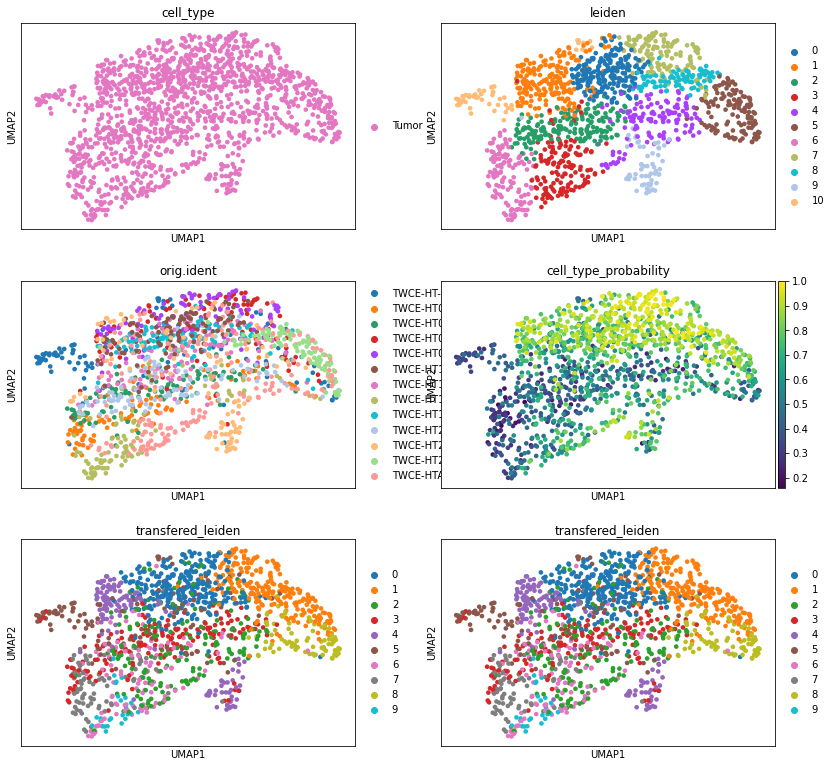

In [104]:
colors = colors + ['transfered_leiden']
sc.pl.umap(m1, color=colors, ncols=2)

invalid value encountered in log2
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


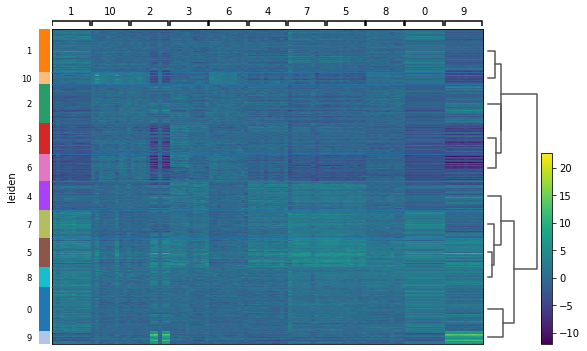

In [110]:
sc.tl.rank_genes_groups(m1, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups_heatmap(m1)

invalid value encountered in log2
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


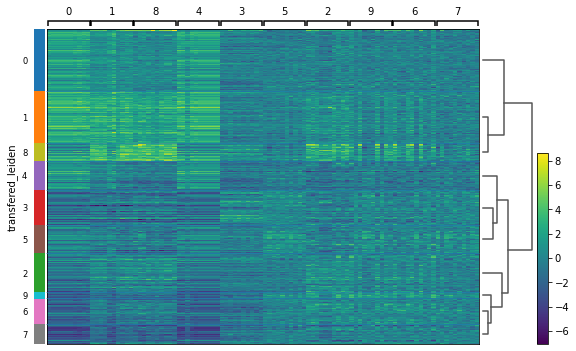

In [106]:
sc.tl.rank_genes_groups(m1, 'transfered_leiden', method='wilcoxon')
sc.pl.rank_genes_groups_heatmap(m1)

In [130]:
m2 = gene_activity.copy()
m2 = m2[explain.obs.index]
m2

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


View of AnnData object with n_obs × n_vars = 1400 × 19891
    obs: 'orig.ident', 'nCount_peaks', 'nFeature_peaks', 'total', 'duplicate', 'chimeric', 'unmapped', 'lowmapq', 'mitochondrial', 'passed_filters', 'cell_id', 'is__cell_barcode', 'TSS_fragments', 'DNase_sensitive_region_fragments', 'enhancer_region_fragments', 'promoter_region_fragments', 'on_target_fragments', 'blacklist_region_fragments', 'peak_region_fragments', 'peak_region_cutsites', 'nucleosome_signal', 'nucleosome_percentile', 'TSS.enrichment', 'TSS.percentile', 'pct_reads_in_peaks', 'blacklist_ratio', 'high.tss', 'nucleosome_group', 'peaks_snn_res.0.8', 'seurat_clusters', 'nCount_RNA', 'nFeature_RNA', 'predicted.id', 'prediction.score.Tumor', 'prediction.score.Fibroblast', 'prediction.score.Endothelial', 'prediction.score.NK', 'prediction.score.CD4_T', 'prediction.score.Macrophage', 'prediction.score.Treg', 'prediction.score.CD8_T', 'prediction.score.Unknown', 'prediction.score.Mast', 'prediction.score.max', 'nCount_pea

In [131]:
sc.pp.neighbors(m2)
sc.pp.pca(m2)

sc.tl.umap(m2)
sc.tl.leiden(m2, resolution=1.)
m2

         Falling back to preprocessing with `sc.pp.pca` and default params.


AnnData object with n_obs × n_vars = 1400 × 19891
    obs: 'orig.ident', 'nCount_peaks', 'nFeature_peaks', 'total', 'duplicate', 'chimeric', 'unmapped', 'lowmapq', 'mitochondrial', 'passed_filters', 'cell_id', 'is__cell_barcode', 'TSS_fragments', 'DNase_sensitive_region_fragments', 'enhancer_region_fragments', 'promoter_region_fragments', 'on_target_fragments', 'blacklist_region_fragments', 'peak_region_fragments', 'peak_region_cutsites', 'nucleosome_signal', 'nucleosome_percentile', 'TSS.enrichment', 'TSS.percentile', 'pct_reads_in_peaks', 'blacklist_ratio', 'high.tss', 'nucleosome_group', 'peaks_snn_res.0.8', 'seurat_clusters', 'nCount_RNA', 'nFeature_RNA', 'predicted.id', 'prediction.score.Tumor', 'prediction.score.Fibroblast', 'prediction.score.Endothelial', 'prediction.score.NK', 'prediction.score.CD4_T', 'prediction.score.Macrophage', 'prediction.score.Treg', 'prediction.score.CD8_T', 'prediction.score.Unknown', 'prediction.score.Mast', 'prediction.score.max', 'nCount_peaksinters

In [132]:
m2.obs['transfered_leiden'] = feature_adata.obs['leiden'].to_list()

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
... storing 'predicted_cell_type' as categorical
... storing 'transfered_leiden' as categorical


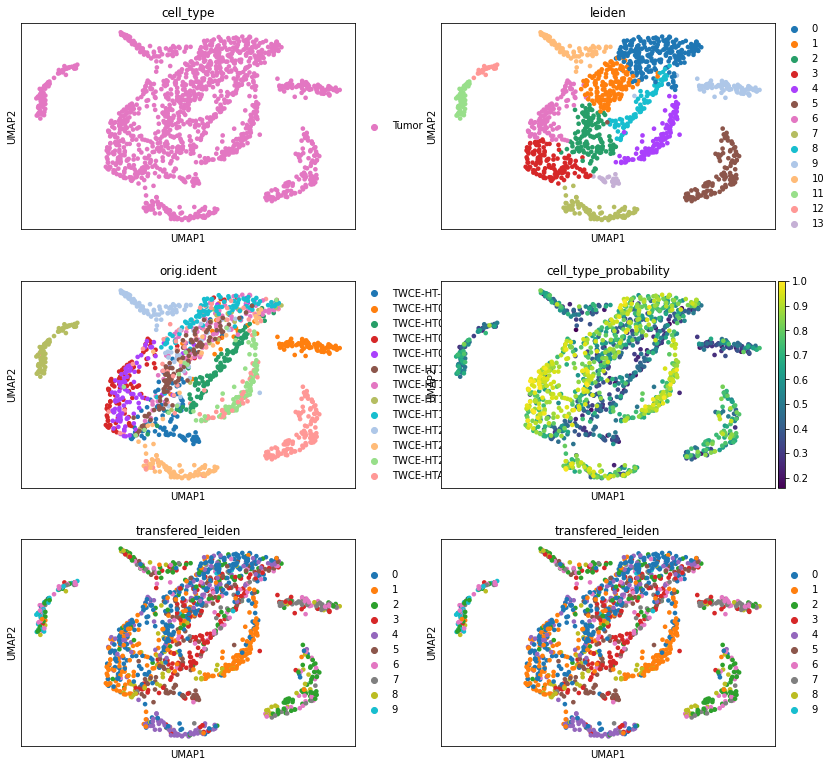

In [133]:
colors = colors
sc.pl.umap(m2, color=colors, ncols=2)

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


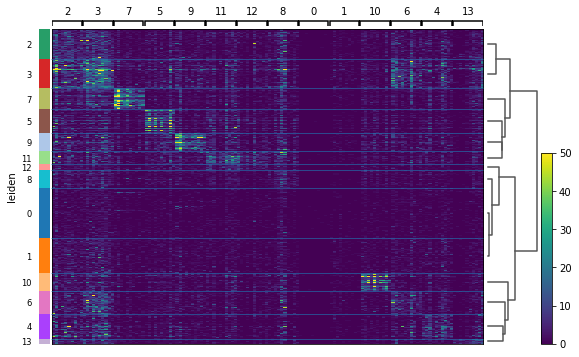

In [137]:
sc.tl.rank_genes_groups(m2, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups_heatmap(m2, vmax=50.)

categories: 0, 1, 2, etc.
var_group_labels: 8


is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


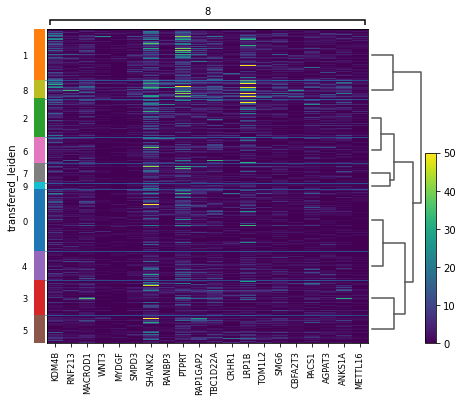

In [144]:
sc.tl.rank_genes_groups(m2, 'transfered_leiden', method='wilcoxon')
sc.pl.rank_genes_groups_heatmap(m2, vmax=50., groups=['8'], n_genes=20)

In [140]:
list(m2.uns['rank_genes_groups']['names']['8'])[:20]

['KDM4B',
 'RNF213',
 'MACROD1',
 'WNT3',
 'MYDGF',
 'SMPD3',
 'SHANK2',
 'RANBP3',
 'PTPRT',
 'RAP1GAP2',
 'TBC1D22A',
 'CRHR1',
 'LRP1B',
 'TOM1L2',
 'SMG6',
 'CBFA2T3',
 'PACS1',
 'AGPAT3',
 'ANKS1A',
 'METTL16']

## annotated ADM

In [5]:
adata = sc.read_h5ad('/home/estorrs/rds_conversion/data/scRNAseq/pdac/pdac_tumor_acinar_adm.h5ad')
module_fp = '../benchmarking/sandbox/pdac_adm_module'

In [6]:
adata

AnnData object with n_obs × n_vars = 26405 × 25368
    obs: b'orig.ident', b'nCount_RNA', b'nFeature_RNA', b'percent.mito', b'nCount_SCT', b'nFeature_SCT', b'SCT_snn_res.0.5', b'seurat_clusters', b'cell_type', b'sample', b'treatment', b'tissue', b'mutations', b'ident'
    var: b'sct.detection_rate', b'sct.gmean', b'sct.variance', b'sct.residual_mean', b'sct.residual_variance', b'sct.variable'
    obsm: 'X_pca', 'X_umap'
    layers: 'logcounts'

In [7]:
adata.obs.columns = adata.obs.columns.astype(str)

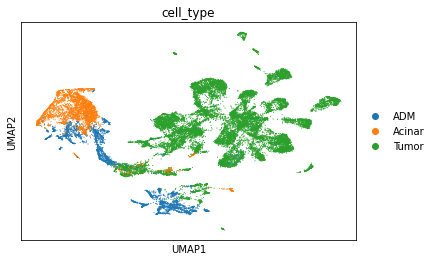

In [8]:
sc.pl.umap(adata, color='cell_type')

In [9]:
train, rest = balancedish_training_generator(adata, 'cell_type', n_per_cell_type=1000, split=1.)
train

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


View of AnnData object with n_obs × n_vars = 3000 × 25368
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mito', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.5', 'seurat_clusters', 'cell_type', 'sample', 'treatment', 'tissue', 'mutations', 'ident'
    var: b'sct.detection_rate', b'sct.gmean', b'sct.variance', b'sct.residual_mean', b'sct.residual_variance', b'sct.variable'
    uns: 'cell_type_colors'
    obsm: 'X_pca', 'X_umap'
    layers: 'logcounts'

In [10]:
## train module
pds = PollockDataset(train.copy(), cell_type_key='cell_type', n_per_cell_type=500,
                    oversample=True, dataset_type='training', )

2020-12-03 10:20:25,390 input dataset shape: (3000, 25368)
2020-12-03 10:20:25,392 possible cell types: ['ADM', 'Acinar', 'Tumor']
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


In [11]:
pm = PollockModel(pds.cell_types, pds.train_adata.shape[1], alpha=.005, latent_dim=25, )

In [12]:
pm.fit(pds, epochs=20)

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2020-12-03 10:20:39,599 epoch: 1, train loss: 65.04656982421875, val loss: 73.31072998046875
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2020-12-03 10:20:45,749 epoch: 2, train loss: 63.44069290161133, val loss: 71.79795837402344
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2020-12-03 10:20:52,616 epoch: 3, train loss: 63.12490463256836, val loss: 71.5638198852539
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype in

In [13]:
pm.save(pds, module_fp)

metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.


Text(33.0, 0.5, 'Groundtruth')

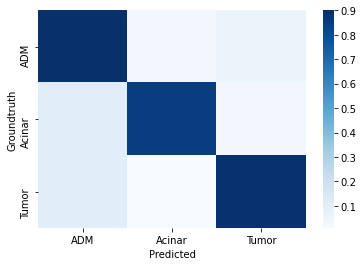

In [14]:
confusion_matrix = pd.DataFrame(data=pm.summary['validation']['confusion_matrix'], columns=pm.class_names,
                  index=pm.class_names)
sns.heatmap(confusion_matrix, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Groundtruth')

In [157]:
predictions = predict_from_anndata(adata.copy(), module_fp)
predictions

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2020-11-23 09:19:18,241 0 genes in training set are missing from prediction set
2020-11-23 09:19:18,673 starting batch 1 of 3
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2020-11-23 09:19:18,951 0 genes in training set are missing from prediction set
2020-11-23 09:19:50,009 starting batch 2 of 3
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2020-11-23 09:19:50,369 0 genes in training set are missing from prediction set
2020-11-23 09:20:21,387 starting batch 3 of 3
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2020-11-23 09:20:21,586 0 genes in training set are missing from prediction set


predicted_cell_type  cell_type_probability  \
HT056P_S1PA_AAAGGTATCCTAGAGT-1                  ADM                   0.49   
HT056P_S1PA_AACACACTCGCTTTAT-1                  ADM                   0.50   
HT056P_S1PA_AAGCGTTGTAGATGTA-1                Tumor                   0.71   
HT056P_S1PA_AAGGAATGTTCCTAAG-1                  ADM                   0.47   
HT056P_S1PA_AAGTTCGCATGGCTAT-1                Tumor                   0.80   
...                                             ...                    ...   
HT168P1_S1H4_TTGGTTTGTAACGCGA-1               Tumor                   0.66   
HT168P1_S1H4_TTTACGTGTATCGCGC-1                 ADM                   0.67   
HT168P1_S1H4_TTTACTGCAGTAGAGC-1               Tumor                   0.85   
HT168P1_S1H4_TTTAGTCTCCCTCATG-1               Tumor                   0.93   
HT168P1_S1H4_TTTGATCGTACCTGTA-1                 ADM                   0.96   

                                 probability_ADM  probability_Acinar  \
HT056P_S1PA_AAAGGTATCCTAGAGT-1              0.49                0.10   
HT056P_S1PA_AACACACTCGCTTTAT-1              0.50                0.12   
HT056P_S1PA_AAGCGTTGTAGATGTA-1              0.17                0.12   
HT056P_S1PA_AAGGAATGTTCCTAAG-1              0.47                0.19   
HT056P_S1PA_AAGTTCGCATGGCTAT-1              0.16                0.04   
...                                          ...                 ...   
HT168P1_S1H4_TTGGTTTGTAACGCGA-1             0.33                0.01   
HT168P1_S1H4_TTTACGTGTATCGCGC-1             0.67                0.00   
HT168P1_S1H4_TTTACTGCAGTAGAGC-1             0.15                0.00   
HT168P1_S1H4_TTTAGTCTCCCTCATG-1             0.06                0.01   
HT168P1_S1H4_TTTGATCGTACCTGTA-1             0.96                0.02   

                                 probability_Tumor  
HT056P_S1PA_AAAGGTATCCTAGAGT-1                0.41  
HT056P_S1PA_AACACACTCGCTTTAT-1                0.38  
HT056P_S1PA_AAGCGTTGTAGATGTA-1                0.71  
HT056P_S1PA_AAGGAATGTTCCTAAG-1                0.34  
HT056P_S1PA_AAGTTCGCATGGCTAT-1                0.80  
...                                            ...  
HT168P1_S1H4_TTGGTTTGTAACGCGA-1               0.66  
HT168P1_S1H4_TTTACGTGTATCGCGC-1               0.33  
HT168P1_S1H4_TTTACTGCAGTAGAGC-1               0.85  
HT168P1_S1H4_TTTAGTCTCCCTCATG-1               0.93  
HT168P1_S1H4_TTTGATCGTACCTGTA-1               0.02  

[26405 rows x 5 columns]

In [158]:
adata.obs = pd.merge(adata.obs, predictions, right_index=True, left_index=True)
adata.obs

orig.ident  nCount_RNA  \
HT056P_S1PA_AAAGGTATCCTAGAGT-1          TWCE-HT056P-S1PAA1-lib1     30323.0   
HT056P_S1PA_AACACACTCGCTTTAT-1          TWCE-HT056P-S1PAA1-lib1      3218.0   
HT056P_S1PA_AAGCGTTGTAGATGTA-1          TWCE-HT056P-S1PAA1-lib1     72154.0   
HT056P_S1PA_AAGGAATGTTCCTAAG-1          TWCE-HT056P-S1PAA1-lib1     38048.0   
HT056P_S1PA_AAGTTCGCATGGCTAT-1          TWCE-HT056P-S1PAA1-lib1      5177.0   
...                                                         ...         ...   
HT168P1_S1H4_TTGGTTTGTAACGCGA-1  TWCE-HT168P1-BC4-HT168P1-BC4_1     12591.0   
HT168P1_S1H4_TTTACGTGTATCGCGC-1  TWCE-HT168P1-BC4-HT168P1-BC4_1      3029.0   
HT168P1_S1H4_TTTACTGCAGTAGAGC-1  TWCE-HT168P1-BC4-HT168P1-BC4_1     22774.0   
HT168P1_S1H4_TTTAGTCTCCCTCATG-1  TWCE-HT168P1-BC4-HT168P1-BC4_1      9942.0   
HT168P1_S1H4_TTTGATCGTACCTGTA-1  TWCE-HT168P1-BC4-HT168P1-BC4_1      4540.0   

                                 nFeature_RNA  percent.mito  nCount_SCT  \
HT056P_S1PA_AAAGGTATCCTAGAGT-1           5356      0.083402      8767.0   
HT056P_S1PA_AACACACTCGCTTTAT-1           1239      0.065879      7633.0   
HT056P_S1PA_AAGCGTTGTAGATGTA-1           8208      0.092704      9153.0   
HT056P_S1PA_AAGGAATGTTCCTAAG-1           5498      0.064576      8880.0   
HT056P_S1PA_AAGTTCGCATGGCTAT-1           2120      0.025497      7554.0   
...                                       ...           ...         ...   
HT168P1_S1H4_TTGGTTTGTAACGCGA-1          4134      0.004845      9369.0   
HT168P1_S1H4_TTTACGTGTATCGCGC-1          1390      0.044569      7455.0   
HT168P1_S1H4_TTTACTGCAGTAGAGC-1          5032      0.044832      8741.0   
HT168P1_S1H4_TTTAGTCTCCCTCATG-1          3795      0.002112      9202.0   
HT168P1_S1H4_TTTGATCGTACCTGTA-1          2132      0.056388      7603.0   

                                 nFeature_SCT SCT_snn_res.0.5 seurat_clusters  \
HT056P_S1PA_AAAGGTATCCTAGAGT-1           2760              24              24   
HT056P_S1PA_AACACACTCGCTTTAT-1           1467              24              24   
HT056P_S1PA_AAGCGTTGTAGATGTA-1           3262              24              24   
HT056P_S1PA_AAGGAATGTTCCTAAG-1           2538              24              24   
HT056P_S1PA_AAGTTCGCATGGCTAT-1           2124              24              24   
...                                       ...             ...             ...   
HT168P1_S1H4_TTGGTTTGTAACGCGA-1          4116               7               7   
HT168P1_S1H4_TTTACGTGTATCGCGC-1          1632               7               7   
HT168P1_S1H4_TTTACTGCAGTAGAGC-1          3229               7               7   
HT168P1_S1H4_TTTAGTCTCCCTCATG-1          3794               7               7   
HT168P1_S1H4_TTTGATCGTACCTGTA-1          2150              20              20   

                                cell_type   sample   treatment tissue  \
HT056P_S1PA_AAAGGTATCCTAGAGT-1      Tumor   HT056P  FOLFIRINOX  Tumor   
HT056P_S1PA_AACACACTCGCTTTAT-1      Tumor   HT056P  FOLFIRINOX  Tumor   
HT056P_S1PA_AAGCGTTGTAGATGTA-1      Tumor   HT056P  FOLFIRINOX  Tumor   
HT056P_S1PA_AAGGAATGTTCCTAAG-1      Tumor   HT056P  FOLFIRINOX  Tumor   
HT056P_S1PA_AAGTTCGCATGGCTAT-1      Tumor   HT056P  FOLFIRINOX  Tumor   
...                                   ...      ...         ...    ...   
HT168P1_S1H4_TTGGTTTGTAACGCGA-1     Tumor  HT168P1  FOLFIRINOX  Tumor   
HT168P1_S1H4_TTTACGTGTATCGCGC-1     Tumor  HT168P1  FOLFIRINOX  Tumor   
HT168P1_S1H4_TTTACTGCAGTAGAGC-1     Tumor  HT168P1  FOLFIRINOX  Tumor   
HT168P1_S1H4_TTTAGTCTCCCTCATG-1     Tumor  HT168P1  FOLFIRINOX  Tumor   
HT168P1_S1H4_TTTGATCGTACCTGTA-1     Tumor  HT168P1  FOLFIRINOX  Tumor   

                                mutations ident predicted_cell_type  \
HT056P_S1PA_AAAGGTATCCTAGAGT-1         NA    24                 ADM   
HT056P_S1PA_AACACACTCGCTTTAT-1         NA    24                 ADM   
HT056P_S1PA_AAGCGTTGTAGATGTA-1         NA    24               Tumor   
HT056P_S1PA_AAGGAATGTTCCTAAG-1         NA    24                 ADM  

In [159]:
embeddings = embed_from_anndata(adata.copy(), module_fp)
embeddings

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2020-11-23 09:20:58,096 0 genes in training set are missing from prediction set
2020-11-23 09:20:58,587 starting batch 1 of 3
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2020-11-23 09:20:59,255 0 genes in training set are missing from prediction set
2020-11-23 09:21:30,257 starting batch 2 of 3
2020-11-23 09:21:30,545 0 genes in training set are missing from prediction set
2020-11-23 09:22:02,003 starting batch 3 of 3
2020-11-23 09:22:02,183 0 genes in training set are missing from prediction set


CELL_EMBEDDING_1  CELL_EMBEDDING_2  \
HT056P_S1PA_AAAGGTATCCTAGAGT-1           2.056486          2.179127   
HT056P_S1PA_AACACACTCGCTTTAT-1           2.642202          1.944685   
HT056P_S1PA_AAGCGTTGTAGATGTA-1           2.629460          4.000878   
HT056P_S1PA_AAGGAATGTTCCTAAG-1           1.890741          1.950101   
HT056P_S1PA_AAGTTCGCATGGCTAT-1           2.889411          3.117203   
...                                           ...               ...   
HT168P1_S1H4_TTGGTTTGTAACGCGA-1          3.510293          4.699711   
HT168P1_S1H4_TTTACGTGTATCGCGC-1          2.088731          2.106235   
HT168P1_S1H4_TTTACTGCAGTAGAGC-1          2.765563          4.148707   
HT168P1_S1H4_TTTAGTCTCCCTCATG-1          2.498046          4.863406   
HT168P1_S1H4_TTTGATCGTACCTGTA-1          3.024310          1.720727   

                                 CELL_EMBEDDING_3  CELL_EMBEDDING_4  \
HT056P_S1PA_AAAGGTATCCTAGAGT-1           2.130949          1.872149   
HT056P_S1PA_AACACACTCGCTTTAT-1           1.866363          1.772209   
HT056P_S1PA_AAGCGTTGTAGATGTA-1           1.041843          3.995455   
HT056P_S1PA_AAGGAATGTTCCTAAG-1           2.153568          1.881704   
HT056P_S1PA_AAGTTCGCATGGCTAT-1           1.568756          2.309657   
...                                           ...               ...   
HT168P1_S1H4_TTGGTTTGTAACGCGA-1          4.880372          3.090708   
HT168P1_S1H4_TTTACGTGTATCGCGC-1          2.107373          1.753175   
HT168P1_S1H4_TTTACTGCAGTAGAGC-1          3.960757          1.961471   
HT168P1_S1H4_TTTAGTCTCCCTCATG-1          5.323696          3.229135   
HT168P1_S1H4_TTTGATCGTACCTGTA-1          1.871051          1.405150   

                                 CELL_EMBEDDING_5  CELL_EMBEDDING_6  \
HT056P_S1PA_AAAGGTATCCTAGAGT-1          -1.425581          1.296676   
HT056P_S1PA_AACACACTCGCTTTAT-1          -0.781661          1.015042   
HT056P_S1PA_AAGCGTTGTAGATGTA-1          -1.076336         -0.094237   
HT056P_S1PA_AAGGAATGTTCCTAAG-1          -1.047248          0.995956   
HT056P_S1PA_AAGTTCGCATGGCTAT-1          -1.052504          1.248054   
...                                           ...               ...   
HT168P1_S1H4_TTGGTTTGTAACGCGA-1         -4.471416          2.936346   
HT168P1_S1H4_TTTACGTGTATCGCGC-1         -1.776596          1.697607   
HT168P1_S1H4_TTTACTGCAGTAGAGC-1         -3.742919          2.229746   
HT168P1_S1H4_TTTAGTCTCCCTCATG-1         -4.648103          1.495336   
HT168P1_S1H4_TTTGATCGTACCTGTA-1         -1.803138          1.953141   

                                 CELL_EMBEDDING_7  CELL_EMBEDDING_8  \
HT056P_S1PA_AAAGGTATCCTAGAGT-1           0.201620         -4.419985   
HT056P_S1PA_AACACACTCGCTTTAT-1           1.010453         -3.503848   
HT056P_S1PA_AAGCGTTGTAGATGTA-1           1.595067         -6.477504   
HT056P_S1PA_AAGGAATGTTCCTAAG-1           0.163260         -4.272331   
HT056P_S1PA_AAGTTCGCATGGCTAT-1           0.778825         -4.289553   
...                                           ...               ...   
HT168P1_S1H4_TTGGTTTGTAACGCGA-1          1.199904         -5.094300   
HT168P1_S1H4_TTTACGTGTATCGCGC-1          1.084073         -2.921991   
HT168P1_S1H4_TTTACTGCAGTAGAGC-1          1.436836         -2.365350   
HT168P1_S1H4_TTTAGTCTCCCTCATG-1          0.137815         -4.369774   
HT168P1_S1H4_TTTGATCGTACCTGTA-1          0.444932         -3.252159   

                                 CELL_EMBEDDING_9  CELL_EMBEDDING_10  ...  \
HT056P_S1PA_AAAGGTATCCTAGAGT-1          -0.056481           3.861436  ...   
HT056P_S1PA_AACACACTCGCTTTAT-1           0.209617           3.804607  ...   
HT056P_S1PA_AAGCGTTGTAGATGTA-1          -0.586919           4.133042  ...   
HT056P_S1PA_AAGGAATGTTCCTAAG-1           0.218489           3.935522  ...   
HT056P_S1PA_AAGTTCGCATGGCTAT-1           0.456688           4.109954  ...   
...                                           ...                ...  ...   
HT168P1_S1H4_TTGGTTTGTAACGCGA-1          0.005062           2.431509  ...   
HT168

In [160]:
adata.obsm['X_embedding'] = embeddings.values

In [161]:
from sklearn.preprocessing import StandardScaler
adata.obsm['X_umap_embedding'] = umap.UMAP().fit_transform(StandardScaler().fit_transform(embeddings.values))

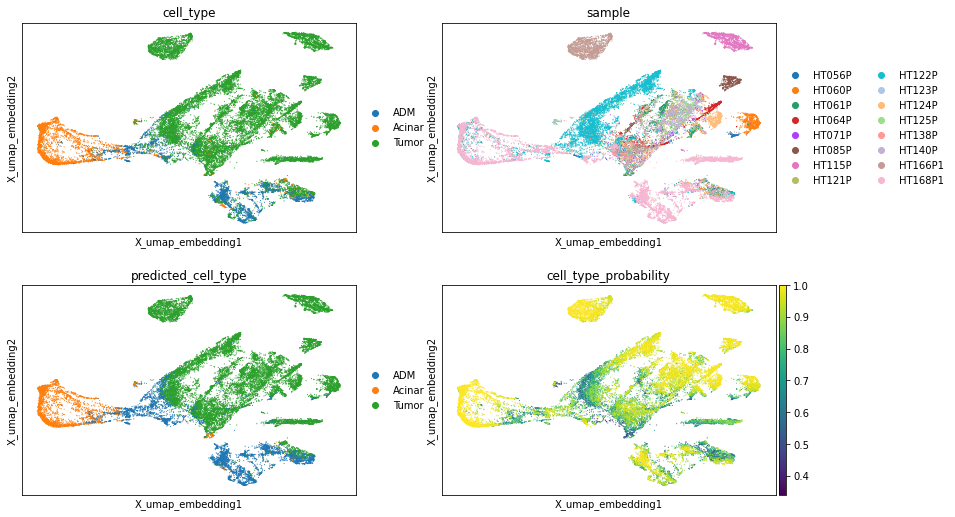

In [170]:
sc.pl.embedding(adata, basis='X_umap_embedding', color=['cell_type', 'sample', 'predicted_cell_type',
                                                       'cell_type_probability'],
               ncols=2)

In [164]:
explain, rest = balancedish_training_generator(adata, cell_type_key='cell_type', n_per_cell_type=50, oversample=False,
                                        split=1.)
background, _ = balancedish_training_generator(rest, cell_type_key='cell_type', n_per_cell_type=25, oversample=False,
                                           split=1.)
explain

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


View of AnnData object with n_obs × n_vars = 150 × 25368
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mito', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.5', 'seurat_clusters', 'cell_type', 'sample', 'treatment', 'tissue', 'mutations', 'ident', 'predicted_cell_type', 'cell_type_probability', 'probability_ADM', 'probability_Acinar', 'probability_Tumor'
    var: b'sct.detection_rate', b'sct.gmean', b'sct.variance', b'sct.residual_mean', b'sct.residual_variance', b'sct.variable'
    uns: 'cell_type_colors', 'sample_colors'
    obsm: 'X_pca', 'X_umap', 'X_embedding', 'X_umap_embedding'
    layers: 'logcounts'

In [165]:
w = explain_predictions(explain.copy(), background.copy(), module_fp)
w

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2020-11-23 09:38:54,952 0 genes in training set are missing from prediction set
2020-11-23 09:38:55,387 starting batch 1 of 1
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2020-11-23 09:38:55,432 0 genes in training set are missing from prediction set
2020-11-23 09:38:55,899 0 genes in training set are missing from prediction set


AL627309.1  AL627309.3  AL627309.4  \
HT060P_S1PB_GTGTGGCGTTGGCTAT-1          0.0         0.0         0.0   
HT060P_S1PB_TCCACGTAGTGCAACG-1          0.0         0.0         0.0   
HT060P_S1PB_TCCGTGTGTTTCGTAG-1          0.0         0.0         0.0   
HT060P_S1R1_CCGGTAGCACCTCTAC-1          0.0         0.0         0.0   
HT061P_S1PA_CAACGATTCCATTTAC-1          0.0         0.0         0.0   
...                                     ...         ...         ...   
HT168P1_S1H3_TGACAGTTCCCAACTC-1         0.0         0.0         0.0   
HT168P1_S1H3_TGATCTTGTGACAACG-1         0.0         0.0         0.0   
HT168P1_S1H3_TGGTGATAGTATCCTG-1         0.0         0.0         0.0   
HT168P1_S1H3_TTGGGATGTAACGTTC-1         0.0         0.0         0.0   
HT168P1_S1H3_TTTGATCAGCGCTGCT-1         0.0         0.0         0.0   

                                 AL669831.2  AL669831.5  FAM87B  LINC00115  \
HT060P_S1PB_GTGTGGCGTTGGCTAT-1          0.0    0.000005     0.0   0.000024   
HT060P_S1PB_TCCACGTAGTGCAACG-1          0.0    0.000014     0.0   0.000021   
HT060P_S1PB_TCCGTGTGTTTCGTAG-1          0.0    0.000001     0.0   0.001120   
HT060P_S1R1_CCGGTAGCACCTCTAC-1          0.0    0.000005     0.0   0.000005   
HT061P_S1PA_CAACGATTCCATTTAC-1          0.0    0.000004     0.0   0.000023   
...                                     ...         ...     ...        ...   
HT168P1_S1H3_TGACAGTTCCCAACTC-1         0.0    0.000001     0.0   0.000023   
HT168P1_S1H3_TGATCTTGTGACAACG-1         0.0    0.000004     0.0   0.000014   
HT168P1_S1H3_TGGTGATAGTATCCTG-1         0.0    0.000015     0.0   0.000017   
HT168P1_S1H3_TTGGGATGTAACGTTC-1         0.0    0.000005     0.0   0.000002   
HT168P1_S1H3_TTTGATCAGCGCTGCT-1         0.0    0.000001     0.0   0.000010   

                                       FAM41C  AL645608.3  AL645608.1  ...  \
HT060P_S1PB_GTGTGGCGTTGGCTAT-1   3.271178e-06         0.0         0.0  ...   
HT060P_S1PB_TCCACGTAGTGCAACG-1   2.216188e-05         0.0         0.0  ...   
HT060P_S1PB_TCCGTGTGTTTCGTAG-1   7.957176e-06         0.0         0.0  ...   
HT060P_S1R1_CCGGTAGCACCTCTAC-1   8.414180e-06         0.0         0.0  ...   
HT061P_S1PA_CAACGATTCCATTTAC-1   6.733860e-07         0.0         0.0  ...   
...                                       ...         ...         ...  ...   
HT168P1_S1H3_TGACAGTTCCCAACTC-1  8.907642e-06         0.0         0.0  ...   
HT168P1_S1H3_TGATCTTGTGACAACG-1  1.524429e-05         0.0         0.0  ...   
HT168P1_S1H3_TGGTGATAGTATCCTG-1  6.945366e-06         0.0         0.0  ...   
HT168P1_S1H3_TTGGGATGTAACGTTC-1  1.497599e-05         0.0         0.0  ...   
HT168P1_S1H3_TTTGATCAGCGCTGCT-1  1.820527e-05         0.0         0.0  ...   

                                 BX004987.1  AC145212.1     MAFIP  AC011043.1  \
HT060P_S1PB_GTGTGGCGTTGGCTAT-1          0.0    0.000053  0.000002    0.000006   
HT060P_S1PB_TCCACGTAGTGCAACG-1          0.0    0.000032  0.000002    0.000048   
HT060P_S1PB_TCCGTGTGTTTCGTAG-1          0.0    0.000016  0.000005    0.000022   
HT060P_S1R1_CCGGTAGCACCTCTAC-1          0.0    0.000016  0.000000    0.000040   
HT061P_S1PA_CAACGATTCCATTTAC-1          0.0    0.000077  0.000000    0.000031   
...                                     ...         ...       ...         ...   
HT168P1_S1H3_TGACAGTTCCCAACTC-1         0.0    0.000004  0.000002    0.000015   
HT168P1_S1H3_TGATCTTGTGACAACG-1         0.0    0.000026  0.000002    0.000023   
HT168P1_S1H3_TGGTGATAGTATCCTG-1         0.0    0.000034  0.000004    0.000036   
HT168P1_S1H3_TTGGGATGTAACGTTC-1         0.0    0.000009  0.000005    0.000086   
HT168P1_S1H3_TTTGATCAGCGCTGCT-1         0.0    0.000000  0.000012    0.000030   

                                 AL592183.1  AC007325.4  AC007325.2  \
HT060P_S1PB_GTGTGGCGTTGGCTAT-1     0.000013    0.000091         0.0   
HT060P_S1PB_TCCACGTAGTGCAACG-1     0.000004    0.000281         0.0   
HT060P_S1PB_TCCGTGTGTTTCGTAG-1     0.000025    0.000038         0.0   
HT060P_S1R1_CCGGTAGCACCTCTAC-1     0.000018    0.

In [166]:
tumor_weights = anndata.AnnData(X=w.values, obs=explain.obs.copy())
tumor_weights.var.index = w.columns
tumor_weights

AnnData object with n_obs × n_vars = 150 × 25368
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mito', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.5', 'seurat_clusters', 'cell_type', 'sample', 'treatment', 'tissue', 'mutations', 'ident', 'predicted_cell_type', 'cell_type_probability', 'probability_ADM', 'probability_Acinar', 'probability_Tumor'

In [167]:
feature_adata = tumor_weights.copy()

feature_adata.obsm['X_umap'] = umap.UMAP().fit_transform(StandardScaler().fit_transform(feature_adata.X))


# sc.pp.scale(feature_adata)
# sc.pp.neighbors(feature_adata)
# sc.pp.pca(feature_adata)

# sc.tl.umap(feature_adata)
# sc.tl.leiden(feature_adata, resolution=1.)
# feature_adata

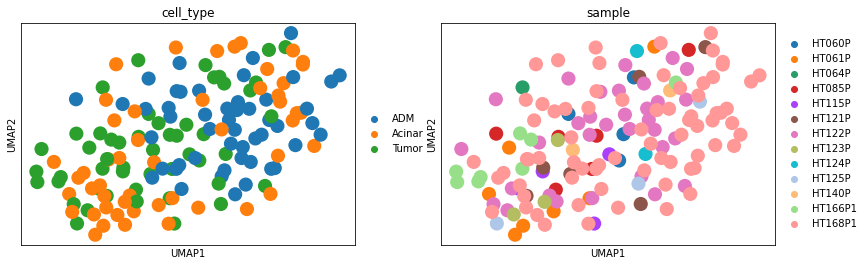

In [168]:
sc.pl.umap(feature_adata, color=['cell_type', 'sample'])

In [171]:
adata = sc.read_h5ad('/home/estorrs/rds_conversion/data/scRNAseq/pdac/pdac_tumor_acinar_adm.h5ad')
module_fp = '../benchmarking/sandbox/pdac_tumor_acinar_module'

In [172]:
adata

AnnData object with n_obs × n_vars = 26405 × 25368
    obs: b'orig.ident', b'nCount_RNA', b'nFeature_RNA', b'percent.mito', b'nCount_SCT', b'nFeature_SCT', b'SCT_snn_res.0.5', b'seurat_clusters', b'cell_type', b'sample', b'treatment', b'tissue', b'mutations', b'ident'
    var: b'sct.detection_rate', b'sct.gmean', b'sct.variance', b'sct.residual_mean', b'sct.residual_variance', b'sct.variable'
    obsm: 'X_pca', 'X_umap'
    layers: 'logcounts'

In [173]:
adata.obs.columns = adata.obs.columns.astype(str)

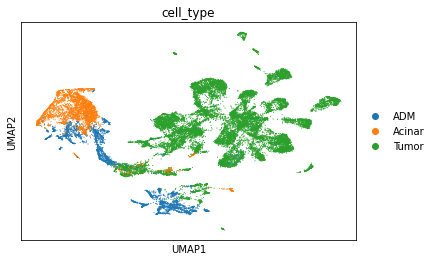

In [174]:
sc.pl.umap(adata, color='cell_type')

In [175]:
filtered = adata[adata.obs['cell_type']!='ADM'].copy()

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


In [176]:
train, rest = balancedish_training_generator(filtered, 'cell_type', n_per_cell_type=2000, split=1.)
train

View of AnnData object with n_obs × n_vars = 4000 × 25368
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mito', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.5', 'seurat_clusters', 'cell_type', 'sample', 'treatment', 'tissue', 'mutations', 'ident'
    var: b'sct.detection_rate', b'sct.gmean', b'sct.variance', b'sct.residual_mean', b'sct.residual_variance', b'sct.variable'
    uns: 'cell_type_colors'
    obsm: 'X_pca', 'X_umap'
    layers: 'logcounts'

In [177]:
## train module
pds = PollockDataset(train.copy(), cell_type_key='cell_type', n_per_cell_type=1000,
                    oversample=True, dataset_type='training', )

2020-11-23 09:46:10,396 input dataset shape: (4000, 25368)
2020-11-23 09:46:10,398 possible cell types: ['Acinar', 'Tumor']
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


In [178]:
pm = PollockModel(pds.cell_types, pds.train_adata.shape[1], alpha=.0001, latent_dim=25, )

In [179]:
pm.fit(pds, epochs=20)

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2020-11-23 09:46:21,692 epoch: 1, train loss: 51.021446228027344, val loss: 61.58369445800781
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2020-11-23 09:46:26,450 epoch: 2, train loss: 49.97924041748047, val loss: 60.641109466552734
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2020-11-23 09:46:31,343 epoch: 3, train loss: 48.65570831298828, val loss: 60.11516571044922
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype

In [180]:
pm.save(pds, module_fp)

metadata on a dtype may be saved or ignored, but will raise if saved when read. Use another form of storage.


Text(33.0, 0.5, 'Groundtruth')

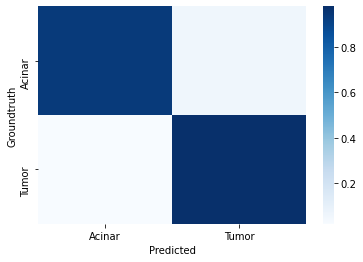

In [181]:
confusion_matrix = pd.DataFrame(data=pm.summary['validation']['confusion_matrix'], columns=pm.class_names,
                  index=pm.class_names)
sns.heatmap(confusion_matrix, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Groundtruth')

In [182]:
predictions = predict_from_anndata(adata.copy(), module_fp)
predictions

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2020-11-23 09:47:57,444 0 genes in training set are missing from prediction set
2020-11-23 09:47:57,766 starting batch 1 of 3
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2020-11-23 09:47:58,042 0 genes in training set are missing from prediction set
2020-11-23 09:48:29,482 starting batch 2 of 3
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2020-11-23 09:48:29,730 0 genes in training set are missing from prediction set
2020-11-23 09:49:00,344 starting batch 3 of 3
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2020-11-23 09:49:00,512 0 genes in training set are missing from prediction set


predicted_cell_type  cell_type_probability  \
HT056P_S1PA_AAAGGTATCCTAGAGT-1                Tumor                   0.93   
HT056P_S1PA_AACACACTCGCTTTAT-1                Tumor                   0.95   
HT056P_S1PA_AAGCGTTGTAGATGTA-1                Tumor                   0.97   
HT056P_S1PA_AAGGAATGTTCCTAAG-1                Tumor                   0.88   
HT056P_S1PA_AAGTTCGCATGGCTAT-1                Tumor                   0.98   
...                                             ...                    ...   
HT168P1_S1H4_TTGGTTTGTAACGCGA-1               Tumor                   0.98   
HT168P1_S1H4_TTTACGTGTATCGCGC-1               Tumor                   0.95   
HT168P1_S1H4_TTTACTGCAGTAGAGC-1               Tumor                   0.99   
HT168P1_S1H4_TTTAGTCTCCCTCATG-1               Tumor                   0.98   
HT168P1_S1H4_TTTGATCGTACCTGTA-1               Tumor                   0.96   

                                 probability_Acinar  probability_Tumor  
HT056P_S1PA_AAAGGTATCCTAGAGT-1                 0.07               0.93  
HT056P_S1PA_AACACACTCGCTTTAT-1                 0.05               0.95  
HT056P_S1PA_AAGCGTTGTAGATGTA-1                 0.03               0.97  
HT056P_S1PA_AAGGAATGTTCCTAAG-1                 0.12               0.88  
HT056P_S1PA_AAGTTCGCATGGCTAT-1                 0.02               0.98  
...                                             ...                ...  
HT168P1_S1H4_TTGGTTTGTAACGCGA-1                0.02               0.98  
HT168P1_S1H4_TTTACGTGTATCGCGC-1                0.05               0.95  
HT168P1_S1H4_TTTACTGCAGTAGAGC-1                0.01               0.99  
HT168P1_S1H4_TTTAGTCTCCCTCATG-1                0.02               0.98  
HT168P1_S1H4_TTTGATCGTACCTGTA-1                0.04               0.96  

[26405 rows x 4 columns]

In [183]:
adata.obs = pd.merge(adata.obs, predictions, right_index=True, left_index=True)
adata.obs

orig.ident  nCount_RNA  \
HT056P_S1PA_AAAGGTATCCTAGAGT-1          TWCE-HT056P-S1PAA1-lib1     30323.0   
HT056P_S1PA_AACACACTCGCTTTAT-1          TWCE-HT056P-S1PAA1-lib1      3218.0   
HT056P_S1PA_AAGCGTTGTAGATGTA-1          TWCE-HT056P-S1PAA1-lib1     72154.0   
HT056P_S1PA_AAGGAATGTTCCTAAG-1          TWCE-HT056P-S1PAA1-lib1     38048.0   
HT056P_S1PA_AAGTTCGCATGGCTAT-1          TWCE-HT056P-S1PAA1-lib1      5177.0   
...                                                         ...         ...   
HT168P1_S1H4_TTGGTTTGTAACGCGA-1  TWCE-HT168P1-BC4-HT168P1-BC4_1     12591.0   
HT168P1_S1H4_TTTACGTGTATCGCGC-1  TWCE-HT168P1-BC4-HT168P1-BC4_1      3029.0   
HT168P1_S1H4_TTTACTGCAGTAGAGC-1  TWCE-HT168P1-BC4-HT168P1-BC4_1     22774.0   
HT168P1_S1H4_TTTAGTCTCCCTCATG-1  TWCE-HT168P1-BC4-HT168P1-BC4_1      9942.0   
HT168P1_S1H4_TTTGATCGTACCTGTA-1  TWCE-HT168P1-BC4-HT168P1-BC4_1      4540.0   

                                 nFeature_RNA  percent.mito  nCount_SCT  \
HT056P_S1PA_AAAGGTATCCTAGAGT-1           5356      0.083402      8767.0   
HT056P_S1PA_AACACACTCGCTTTAT-1           1239      0.065879      7633.0   
HT056P_S1PA_AAGCGTTGTAGATGTA-1           8208      0.092704      9153.0   
HT056P_S1PA_AAGGAATGTTCCTAAG-1           5498      0.064576      8880.0   
HT056P_S1PA_AAGTTCGCATGGCTAT-1           2120      0.025497      7554.0   
...                                       ...           ...         ...   
HT168P1_S1H4_TTGGTTTGTAACGCGA-1          4134      0.004845      9369.0   
HT168P1_S1H4_TTTACGTGTATCGCGC-1          1390      0.044569      7455.0   
HT168P1_S1H4_TTTACTGCAGTAGAGC-1          5032      0.044832      8741.0   
HT168P1_S1H4_TTTAGTCTCCCTCATG-1          3795      0.002112      9202.0   
HT168P1_S1H4_TTTGATCGTACCTGTA-1          2132      0.056388      7603.0   

                                 nFeature_SCT SCT_snn_res.0.5 seurat_clusters  \
HT056P_S1PA_AAAGGTATCCTAGAGT-1           2760              24              24   
HT056P_S1PA_AACACACTCGCTTTAT-1           1467              24              24   
HT056P_S1PA_AAGCGTTGTAGATGTA-1           3262              24              24   
HT056P_S1PA_AAGGAATGTTCCTAAG-1           2538              24              24   
HT056P_S1PA_AAGTTCGCATGGCTAT-1           2124              24              24   
...                                       ...             ...             ...   
HT168P1_S1H4_TTGGTTTGTAACGCGA-1          4116               7               7   
HT168P1_S1H4_TTTACGTGTATCGCGC-1          1632               7               7   
HT168P1_S1H4_TTTACTGCAGTAGAGC-1          3229               7               7   
HT168P1_S1H4_TTTAGTCTCCCTCATG-1          3794               7               7   
HT168P1_S1H4_TTTGATCGTACCTGTA-1          2150              20              20   

                                cell_type   sample   treatment tissue  \
HT056P_S1PA_AAAGGTATCCTAGAGT-1      Tumor   HT056P  FOLFIRINOX  Tumor   
HT056P_S1PA_AACACACTCGCTTTAT-1      Tumor   HT056P  FOLFIRINOX  Tumor   
HT056P_S1PA_AAGCGTTGTAGATGTA-1      Tumor   HT056P  FOLFIRINOX  Tumor   
HT056P_S1PA_AAGGAATGTTCCTAAG-1      Tumor   HT056P  FOLFIRINOX  Tumor   
HT056P_S1PA_AAGTTCGCATGGCTAT-1      Tumor   HT056P  FOLFIRINOX  Tumor   
...                                   ...      ...         ...    ...   
HT168P1_S1H4_TTGGTTTGTAACGCGA-1     Tumor  HT168P1  FOLFIRINOX  Tumor   
HT168P1_S1H4_TTTACGTGTATCGCGC-1     Tumor  HT168P1  FOLFIRINOX  Tumor   
HT168P1_S1H4_TTTACTGCAGTAGAGC-1     Tumor  HT168P1  FOLFIRINOX  Tumor   
HT168P1_S1H4_TTTAGTCTCCCTCATG-1     Tumor  HT168P1  FOLFIRINOX  Tumor   
HT168P1_S1H4_TTTGATCGTACCTGTA-1     Tumor  HT168P1  FOLFIRINOX  Tumor   

                                mutations ident predicted_cell_type  \
HT056P_S1PA_AAAGGTATCCTAGAGT-1         NA    24               Tumor   
HT056P_S1PA_AACACACTCGCTTTAT-1         NA    24               Tumor   
HT056P_S1PA_AAGCGTTGTAGATGTA-1         NA    24               Tumor   
HT056P_S1PA_AAGGAATGTTCCTAAG-1         NA    24               Tumor  

In [184]:
embeddings = embed_from_anndata(adata.copy(), module_fp)
embeddings

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2020-11-23 09:49:18,758 0 genes in training set are missing from prediction set
2020-11-23 09:49:19,103 starting batch 1 of 3
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2020-11-23 09:49:19,499 0 genes in training set are missing from prediction set
2020-11-23 09:49:50,282 starting batch 2 of 3
2020-11-23 09:49:50,559 0 genes in training set are missing from prediction set
2020-11-23 09:50:21,772 starting batch 3 of 3
2020-11-23 09:50:21,933 0 genes in training set are missing from prediction set


CELL_EMBEDDING_1  CELL_EMBEDDING_2  \
HT056P_S1PA_AAAGGTATCCTAGAGT-1           3.368659         -2.807051   
HT056P_S1PA_AACACACTCGCTTTAT-1           2.221439         -2.181442   
HT056P_S1PA_AAGCGTTGTAGATGTA-1           2.439197         -4.084064   
HT056P_S1PA_AAGGAATGTTCCTAAG-1           3.302580         -2.256047   
HT056P_S1PA_AAGTTCGCATGGCTAT-1           2.024782         -3.009845   
...                                           ...               ...   
HT168P1_S1H4_TTGGTTTGTAACGCGA-1         -0.522124         -1.831443   
HT168P1_S1H4_TTTACGTGTATCGCGC-1          1.230948         -0.976338   
HT168P1_S1H4_TTTACTGCAGTAGAGC-1          0.353225         -0.983872   
HT168P1_S1H4_TTTAGTCTCCCTCATG-1         -1.072396         -0.346967   
HT168P1_S1H4_TTTGATCGTACCTGTA-1          2.207547         -1.458969   

                                 CELL_EMBEDDING_3  CELL_EMBEDDING_4  \
HT056P_S1PA_AAAGGTATCCTAGAGT-1          -0.127596          0.743836   
HT056P_S1PA_AACACACTCGCTTTAT-1          -1.104256          2.245994   
HT056P_S1PA_AAGCGTTGTAGATGTA-1           0.806342          1.231782   
HT056P_S1PA_AAGGAATGTTCCTAAG-1          -0.081470          0.177460   
HT056P_S1PA_AAGTTCGCATGGCTAT-1          -0.995932          1.888725   
...                                           ...               ...   
HT168P1_S1H4_TTGGTTTGTAACGCGA-1         -1.344249          2.841703   
HT168P1_S1H4_TTTACGTGTATCGCGC-1         -1.117219          2.035543   
HT168P1_S1H4_TTTACTGCAGTAGAGC-1         -0.729372          1.615654   
HT168P1_S1H4_TTTAGTCTCCCTCATG-1         -1.302912          3.639737   
HT168P1_S1H4_TTTGATCGTACCTGTA-1         -1.003025          2.758600   

                                 CELL_EMBEDDING_5  CELL_EMBEDDING_6  \
HT056P_S1PA_AAAGGTATCCTAGAGT-1          -3.956203         -0.569113   
HT056P_S1PA_AACACACTCGCTTTAT-1          -3.491441         -0.896187   
HT056P_S1PA_AAGCGTTGTAGATGTA-1          -5.304149         -1.097896   
HT056P_S1PA_AAGGAATGTTCCTAAG-1          -3.525244         -0.881371   
HT056P_S1PA_AAGTTCGCATGGCTAT-1          -3.928672         -1.285847   
...                                           ...               ...   
HT168P1_S1H4_TTGGTTTGTAACGCGA-1         -4.573904         -5.437885   
HT168P1_S1H4_TTTACGTGTATCGCGC-1         -3.132040         -2.355628   
HT168P1_S1H4_TTTACTGCAGTAGAGC-1         -2.957841         -3.314702   
HT168P1_S1H4_TTTAGTCTCCCTCATG-1         -4.569065         -5.048038   
HT168P1_S1H4_TTTGATCGTACCTGTA-1         -3.366656         -1.431619   

                                 CELL_EMBEDDING_7  CELL_EMBEDDING_8  \
HT056P_S1PA_AAAGGTATCCTAGAGT-1           0.924020         -5.119092   
HT056P_S1PA_AACACACTCGCTTTAT-1           0.615770         -3.394974   
HT056P_S1PA_AAGCGTTGTAGATGTA-1           1.204838         -6.429866   
HT056P_S1PA_AAGGAATGTTCCTAAG-1           0.305068         -4.648095   
HT056P_S1PA_AAGTTCGCATGGCTAT-1           1.113077         -4.430546   
...                                           ...               ...   
HT168P1_S1H4_TTGGTTTGTAACGCGA-1          1.988416         -5.491015   
HT168P1_S1H4_TTTACGTGTATCGCGC-1          0.806578         -3.078466   
HT168P1_S1H4_TTTACTGCAGTAGAGC-1          1.271312         -3.683105   
HT168P1_S1H4_TTTAGTCTCCCTCATG-1          3.654940         -5.832539   
HT168P1_S1H4_TTTGATCGTACCTGTA-1          1.608019         -3.957628   

                                 CELL_EMBEDDING_9  CELL_EMBEDDING_10  ...  \
HT056P_S1PA_AAAGGTATCCTAGAGT-1          -0.487594           0.021022  ...   
HT056P_S1PA_AACACACTCGCTTTAT-1          -0.632324           0.232174  ...   
HT056P_S1PA_AAGCGTTGTAGATGTA-1          -0.424910           2.519695  ...   
HT056P_S1PA_AAGGAATGTTCCTAAG-1          -0.126072           0.123925  ...   
HT056P_S1PA_AAGTTCGCATGGCTAT-1          -1.168218           0.484259  ...   
...                                           ...                ...  ...   
HT168P1_S1H4_TTGGTTTGTAACGCGA-1         -2.221177          -1.718138  ...   
HT168

In [185]:
adata.obsm['X_embedding'] = embeddings.values

In [186]:
from sklearn.preprocessing import StandardScaler
adata.obsm['X_umap_embedding'] = umap.UMAP().fit_transform(StandardScaler().fit_transform(embeddings.values))

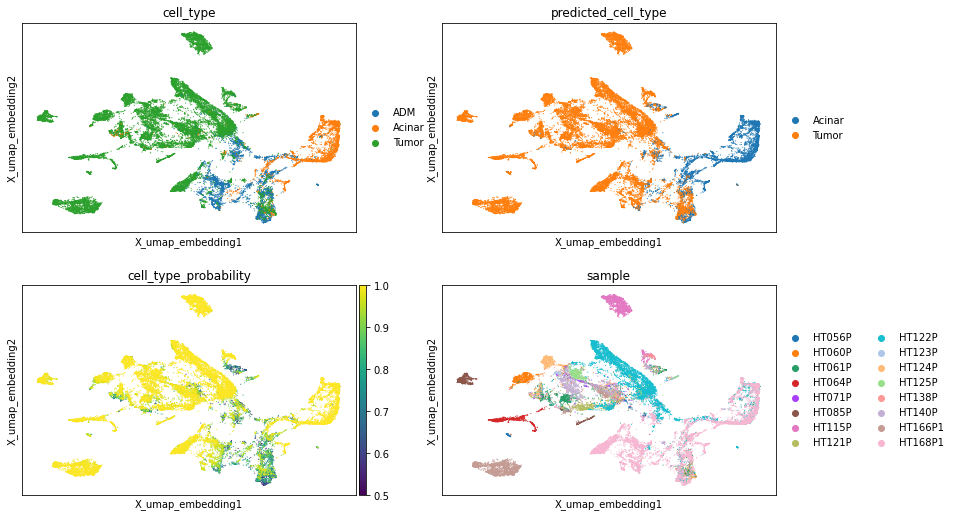

In [188]:
sc.pl.embedding(adata, basis='X_umap_embedding', color=['cell_type', 'predicted_cell_type',
                                                        'cell_type_probability', 'sample'],
               ncols=2)

In [189]:
explain, rest = balancedish_training_generator(adata, cell_type_key='cell_type', n_per_cell_type=200, oversample=False,
                                        split=1.)
background, _ = balancedish_training_generator(rest, cell_type_key='cell_type', n_per_cell_type=50, oversample=False,
                                           split=1.)
explain

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


View of AnnData object with n_obs × n_vars = 600 × 25368
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mito', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.5', 'seurat_clusters', 'cell_type', 'sample', 'treatment', 'tissue', 'mutations', 'ident', 'predicted_cell_type', 'cell_type_probability', 'probability_Acinar', 'probability_Tumor'
    var: b'sct.detection_rate', b'sct.gmean', b'sct.variance', b'sct.residual_mean', b'sct.residual_variance', b'sct.variable'
    uns: 'cell_type_colors', 'predicted_cell_type_colors', 'sample_colors'
    obsm: 'X_pca', 'X_umap', 'X_embedding', 'X_umap_embedding'
    layers: 'logcounts'

In [191]:
explain.obs['explain_cell_types'] = 'Tumor'

Trying to set attribute `.obs` of view, copying.


In [192]:
w = explain_predictions(explain.copy(), background.copy(), module_fp, prediction_key='explain_cell_types')
w

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
... storing 'explain_cell_types' as categorical
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2020-11-23 11:41:43,474 0 genes in training set are missing from prediction set
2020-11-23 11:41:44,015 starting batch 1 of 1
is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
2020-11-23 11:41:44,412 0 genes in training set are missing from prediction set
2020-11-23 11:41:45,902 0 genes in training set are missing from prediction set


AL627309.1  AL627309.3  AL627309.4  \
HT056P_S1PA_ACTGATGTCCGAGCTG-1          0.0         0.0         0.0   
HT056P_S1PA_CCTCAACAGCAGCACA-1          0.0         0.0         0.0   
HT056P_S1PA_GCTGGGTAGCGATGCA-1          0.0         0.0         0.0   
HT056P_S1PA_GGTGTCGGTTAGGGTG-1          0.0         0.0         0.0   
HT056P_S1PA_TCCTCCCCAGGCATTT-1          0.0         0.0         0.0   
...                                     ...         ...         ...   
HT168P1_S1H3_TTTCATGAGGCCCAAA-1         0.0         0.0         0.0   
HT168P1_S1H3_TTTCGATGTGATACCT-1         0.0         0.0         0.0   
HT168P1_S1H3_TTTGACTCACTATCCC-1         0.0         0.0         0.0   
HT168P1_S1H4_AGGTCATTCCACAGGC-1         0.0         0.0         0.0   
HT168P1_S1H4_TAAGCGTGTCAAAGAT-1         0.0         0.0         0.0   

                                 AL669831.2  AL669831.5  FAM87B     LINC00115  \
HT056P_S1PA_ACTGATGTCCGAGCTG-1          0.0    0.000027     0.0  3.658493e-06   
HT056P_S1PA_CCTCAACAGCAGCACA-1          0.0    0.000019     0.0  5.251650e-06   
HT056P_S1PA_GCTGGGTAGCGATGCA-1          0.0    0.000002     0.0  1.377739e-05   
HT056P_S1PA_GGTGTCGGTTAGGGTG-1          0.0    0.000020     0.0  1.571655e-07   
HT056P_S1PA_TCCTCCCCAGGCATTT-1          0.0    0.000033     0.0  1.569035e-06   
...                                     ...         ...     ...           ...   
HT168P1_S1H3_TTTCATGAGGCCCAAA-1         0.0    0.000016     0.0  2.378215e-06   
HT168P1_S1H3_TTTCGATGTGATACCT-1         0.0    0.000016     0.0  3.199081e-06   
HT168P1_S1H3_TTTGACTCACTATCCC-1         0.0    0.000014     0.0  5.570537e-06   
HT168P1_S1H4_AGGTCATTCCACAGGC-1         0.0    0.000014     0.0  1.677734e-06   
HT168P1_S1H4_TAAGCGTGTCAAAGAT-1         0.0    0.000004     0.0  4.673032e-07   

                                       FAM41C  AL645608.3  AL645608.1  ...  \
HT056P_S1PA_ACTGATGTCCGAGCTG-1   2.243508e-06         0.0         0.0  ...   
HT056P_S1PA_CCTCAACAGCAGCACA-1   4.681746e-07         0.0         0.0  ...   
HT056P_S1PA_GCTGGGTAGCGATGCA-1   2.498461e-05         0.0         0.0  ...   
HT056P_S1PA_GGTGTCGGTTAGGGTG-1   1.085386e-05         0.0         0.0  ...   
HT056P_S1PA_TCCTCCCCAGGCATTT-1   1.332847e-06         0.0         0.0  ...   
...                                       ...         ...         ...  ...   
HT168P1_S1H3_TTTCATGAGGCCCAAA-1  3.541142e-05         0.0         0.0  ...   
HT168P1_S1H3_TTTCGATGTGATACCT-1  8.636071e-06         0.0         0.0  ...   
HT168P1_S1H3_TTTGACTCACTATCCC-1  1.623620e-05         0.0         0.0  ...   
HT168P1_S1H4_AGGTCATTCCACAGGC-1  5.478250e-08         0.0         0.0  ...   
HT168P1_S1H4_TAAGCGTGTCAAAGAT-1  1.371841e-05         0.0         0.0  ...   

                                 BX004987.1  AC145212.1  MAFIP  AC011043.1  \
HT056P_S1PA_ACTGATGTCCGAGCTG-1          0.0         0.0    0.0    0.000019   
HT056P_S1PA_CCTCAACAGCAGCACA-1          0.0         0.0    0.0    0.000005   
HT056P_S1PA_GCTGGGTAGCGATGCA-1          0.0         0.0    0.0    0.000011   
HT056P_S1PA_GGTGTCGGTTAGGGTG-1          0.0         0.0    0.0    0.000017   
HT056P_S1PA_TCCTCCCCAGGCATTT-1          0.0         0.0    0.0    0.000053   
...                                     ...         ...    ...         ...   
HT168P1_S1H3_TTTCATGAGGCCCAAA-1         0.0         0.0    0.0    0.000030   
HT168P1_S1H3_TTTCGATGTGATACCT-1         0.0         0.0    0.0    0.000029   
HT168P1_S1H3_TTTGACTCACTATCCC-1         0.0         0.0    0.0    0.001125   
HT168P1_S1H4_AGGTCATTCCACAGGC-1         0.0         0.0    0.0    0.000025   
HT168P1_S1H4_TAAGCGTGTCAAAGAT-1         0.0         0.0    0.0    0.000021   

                                 AL592183.1    AC007325.4  AC007325.2  \
HT056P_S1PA_ACTGATGTCCGAGCTG-1     0.000017  0.000000e+00    0.000062   
HT056P_S1PA_CCTCAACAGCAGCACA-1     0.000012  2.920930e-06    0.000030   
HT056P_S1PA_GCTGGGTAGCGATGCA-1     0.000028  3.649189e-06    0.000082   
HT056P_S1PA_GGTGTCGGTTAGGGTG-1     0.0000

In [193]:
tumor_weights = anndata.AnnData(X=w.values, obs=explain.obs.copy())
tumor_weights.var.index = w.columns
tumor_weights

AnnData object with n_obs × n_vars = 600 × 25368
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mito', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.5', 'seurat_clusters', 'cell_type', 'sample', 'treatment', 'tissue', 'mutations', 'ident', 'predicted_cell_type', 'cell_type_probability', 'probability_Acinar', 'probability_Tumor', 'explain_cell_types'

In [198]:
feature_adata = tumor_weights.copy()

# feature_adata.obsm['X_umap'] = umap.UMAP().fit_transform(StandardScaler().fit_transform(feature_adata.X))


sc.pp.scale(feature_adata)
sc.pp.neighbors(feature_adata)
sc.pp.pca(feature_adata)

sc.tl.umap(feature_adata)
sc.tl.leiden(feature_adata, resolution=1.)
feature_adata

         Falling back to preprocessing with `sc.pp.pca` and default params.


AnnData object with n_obs × n_vars = 600 × 25368
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mito', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.5', 'seurat_clusters', 'cell_type', 'sample', 'treatment', 'tissue', 'mutations', 'ident', 'predicted_cell_type', 'cell_type_probability', 'probability_Acinar', 'probability_Tumor', 'explain_cell_types', 'leiden'
    var: 'mean', 'std'
    uns: 'neighbors', 'pca', 'umap', 'leiden'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
... storing 'explain_cell_types' as categorical


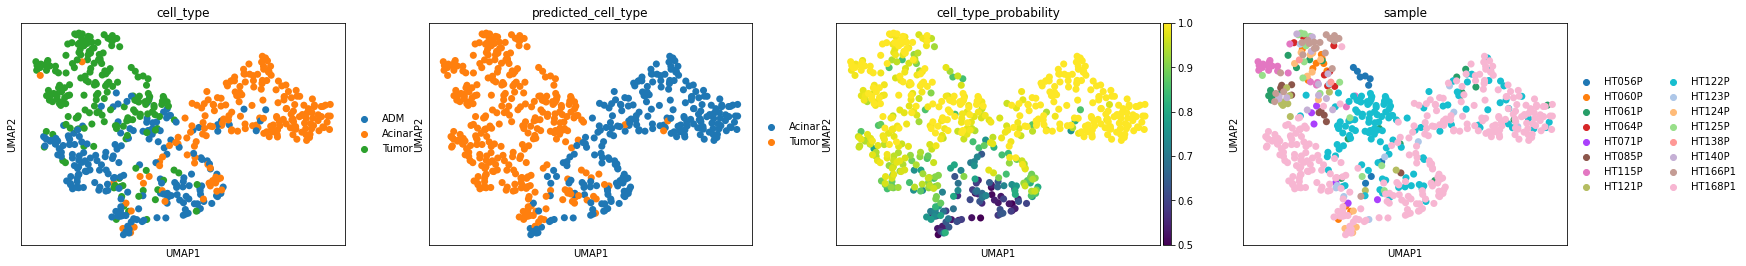

In [199]:
sc.pl.umap(feature_adata, color=['cell_type', 'predicted_cell_type',
                                                        'cell_type_probability', 'sample'])

In [197]:
set(adata.X[:10].toarray().flatten())

{0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 20.0,
 21.0,
 22.0,
 23.0,
 24.0,
 25.0,
 26.0,
 27.0,
 28.0,
 29.0,
 30.0,
 31.0,
 32.0,
 33.0,
 34.0,
 35.0,
 36.0,
 37.0,
 38.0,
 39.0,
 40.0,
 41.0,
 42.0,
 43.0,
 44.0,
 45.0,
 46.0,
 47.0,
 48.0,
 49.0,
 50.0,
 51.0,
 52.0,
 53.0,
 54.0,
 55.0,
 56.0,
 57.0,
 58.0,
 59.0,
 60.0,
 61.0,
 62.0,
 63.0,
 64.0,
 65.0,
 66.0,
 67.0,
 68.0,
 69.0,
 70.0,
 71.0,
 72.0,
 73.0,
 74.0,
 75.0,
 76.0,
 77.0,
 78.0,
 79.0,
 80.0,
 81.0,
 82.0,
 83.0,
 84.0,
 85.0,
 87.0,
 88.0,
 89.0,
 90.0,
 91.0,
 92.0,
 94.0,
 97.0,
 101.0,
 102.0,
 103.0,
 104.0,
 105.0,
 107.0,
 108.0,
 109.0,
 110.0,
 111.0,
 114.0,
 115.0,
 116.0,
 117.0,
 120.0,
 121.0,
 122.0,
 124.0,
 128.0,
 132.0,
 136.0,
 142.0,
 149.0,
 163.0,
 167.0,
 168.0,
 169.0,
 179.0,
 186.0,
 187.0,
 191.0,
 192.0,
 195.0,
 196.0,
 200.0,
 244.0,
 251.0,
 255.0,
 268.0,
 299.0,
 338.0,
 354.0,
 458.0,
 503.0,
